<b>Patterns and rates of soil movement and shallow failures across several small watersheds on the Seward Peninsula, Alaska</b>

Del Vecchio et al

In [1]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.gridspec import  GridSpec
from matplotlib.lines import Line2D
from rasterio import Affine, MemoryFile
from rasterio.enums import Resampling
from contextlib import contextmanager  
from matplotlib import ticker, cm
from matplotlib import colors
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from rasterio.plot import show
from shapely.geometry import Point
from rasterstats import zonal_stats
import rioxarray as rxr
import geopandas as gpd
import seaborn as sns
import pandas as pd
import numpy.ma as ma
import richdem as rd
import numpy as np
import rasterio.mask
import numpy as np
import matplotlib
import fiona
import rasterio
import xarray
import glob
import os

In [45]:
data_path = "./Teller_47_Data/"

figure_path = "./output_figures/"
isExist = os.path.exists(figure_path)
if not isExist:

   # Create a new directory because it does not exist
   os.makedirs(figure_path)

## Create topo and slope maps from ArcticDEM

We are going to build a new slope map from the source DEM since we want to eliminate microtopography from our slope maps. So we coarsen the DEM to 10 meters from 2, then calculate slope on that raster, then upscale that raster back to 2 m so we can compare it with the 2 m drainage area array

In [3]:


# use context manager so DatasetReader and MemoryFile get cleaned up automatically
@contextmanager
def resample_raster(raster, target_res):
    # Forces into original target shape, will rewrite it for a better function later
    target_shape=(1979, 1818)
    
    t = raster.transform

    # rescale the metadata
    scale = t[0]/target_res
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    
    if raster.shape == target_shape:
        height = int(raster.height * scale)
        width = int(raster.width * scale)
    else: 
        height = target_shape[0]
        width = target_shape[1]
            

    profile = raster.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width),
            resampling=Resampling.cubic,
        )

    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset: # Open as DatasetWriter
            dataset.write(data)                     
            del data

        with memfile.open() as dataset:  # Reopen as DatasetReader
            yield dataset  # Note yield not return     


with rasterio.open(data_path+'Teller_47_Data_Rasters//t47_dem.tif') as src:
    with resample_raster(src, target_res=10) as resampled:
        print('Orig dims: {}, New dims: {}'.format(src.shape, resampled.shape))
        print(repr(resampled))
        out_meta = resampled.meta.copy()
        with rasterio.open("new_dem.tif","w",**out_meta) as dest:
            dest.write(resampled.read(1),1)
        
        elev_10m = rd.LoadGDAL("new_dem.tif")
        new_slope = rd.TerrainAttribute(elev_10m, attrib='slope_degrees')

        with rasterio.open("new_slope.tif","w",**out_meta) as dest:
            print('Slope dims: {}'.format(dest.shape))
            dest.write(new_slope, 1) #https://gis.stackexchange.com/questions/279953/numpy-array-to-gtiff-using-rasterio-without-source-raster
        #plt.imshow(new_slope)
        
        with rasterio.open("new_slope.tif") as src:
            with resample_raster(src, target_res=2) as resampled:
                print('Orig dims: {}, New dims: {}'.format(src.shape, resampled.shape))
                print(repr(resampled))
                out_meta = resampled.meta.copy()
                with rasterio.open("new_slope_2m.tif","w",**out_meta) as dest:
                    dest.write(resampled.read(1),1)

        
        
        
#https://gis.stackexchange.com/questions/329434/creating-an-in-memory-rasterio-dataset-from-numpy-array/329439#329439
#with edits by me to turn height and width to integer if you want to downscale
#and automated scaling after providing desired output resolution (a little more intuitive)

Orig dims: (1979, 1818), New dims: (395, 363)
<open DatasetReader name='/vsimem/d037924d-a0e0-4e0f-bd9c-a638adff9524/d037924d-a0e0-4e0f-bd9c-a638adff9524.tif' mode='r'>
Slope dims: (395, 363)
Orig dims: (395, 363), New dims: (1979, 1818)
<open DatasetReader name='/vsimem/547d3082-a2c5-45cf-9ba6-42cd2bfcbef7/547d3082-a2c5-45cf-9ba6-42cd2bfcbef7.tif' mode='r'>



A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.00829201===================== ] (99% - 0.0s - 1 threads)


In [4]:
with rasterio.open(data_path+'Teller_47_Data_Rasters//t47_dem.tif') as src:
    print(src.shape)
    print(src.transform)
    print(src.bounds)
    src.close()
with rasterio.open('new_slope_2m.tif') as src:
    print(src.shape)
    print(src.transform)
    print(src.bounds)
    src.close()

(1979, 1818)
| 2.00, 0.00, 440233.27|
| 0.00,-2.00, 7208172.55|
| 0.00, 0.00, 1.00|
BoundingBox(left=440233.27359348664, bottom=7204214.545356374, right=443869.27359348664, top=7208172.545356374)
(1979, 1818)
| 2.00, 0.00, 440233.27|
| 0.00,-2.00, 7208172.55|
| 0.00, 0.00, 1.00|
BoundingBox(left=440233.27359348664, bottom=7204214.545356374, right=443869.27359348664, top=7208172.545356374)


# Overview map

## Code to import geospatial data

In [5]:
# Regional maps from Google Earth Engine (see script)

regional_dem = os.path.join(data_path,"Teller_47_Data_Maps/regional_dem.tif")
regional_slope = os.path.join(data_path,"Teller_47_Data_Maps/regional_slope.tif")
water_vectors = os.path.join(data_path,"Teller_47_Data_Maps/water_vectors.shp")

t47_dem = rasterio.open(os.path.join(data_path,"Teller_47_Data_Maps/zoom_dem.tif"))
t47_slope = rasterio.open(os.path.join(data_path,"Teller_47_Data_Maps/zoom_slope.tif"))

dem = rasterio.open(regional_dem)
slope = rasterio.open(regional_slope)
water = gpd.read_file(water_vectors)

In [6]:
# Make water mask
water = water[water['water'] == 1]
water = water.to_crs('EPSG:32603')

In [7]:
# Create a shapefile from target positions in UTM Zone 3N
average_cleaned_final = pd.read_csv(os.path.join(data_path,"Teller_47_Data_dGPS//target_locs_cleaned.csv"))
geometry = [Point(xy) for xy in zip(average_cleaned_final['Easting_2019_y'], average_cleaned_final['Northing_2019_y'])]
sites_3N = gpd.GeoDataFrame(average_cleaned_final, crs="EPSG:32603", geometry=geometry)

In [8]:
# Make a zoom-in box
sites_3N_box=[
            sites_3N.total_bounds[0],
              sites_3N.total_bounds[2],
              sites_3N.total_bounds[1],
              sites_3N.total_bounds[3]
             ]
box_params = [(sites_3N_box[0],sites_3N_box[3]),
              (sites_3N_box[1]-sites_3N_box[0]),
              (sites_3N_box[2]-sites_3N_box[3])]

In [9]:
# Load InSAR hillslope sites (see end of notebook)
insar_pts = gpd.read_file((os.path.join(data_path,"Teller_47_Data_Shapefiles//insar_pts.shp"))).to_crs("EPSG:32603")

## Code to make map

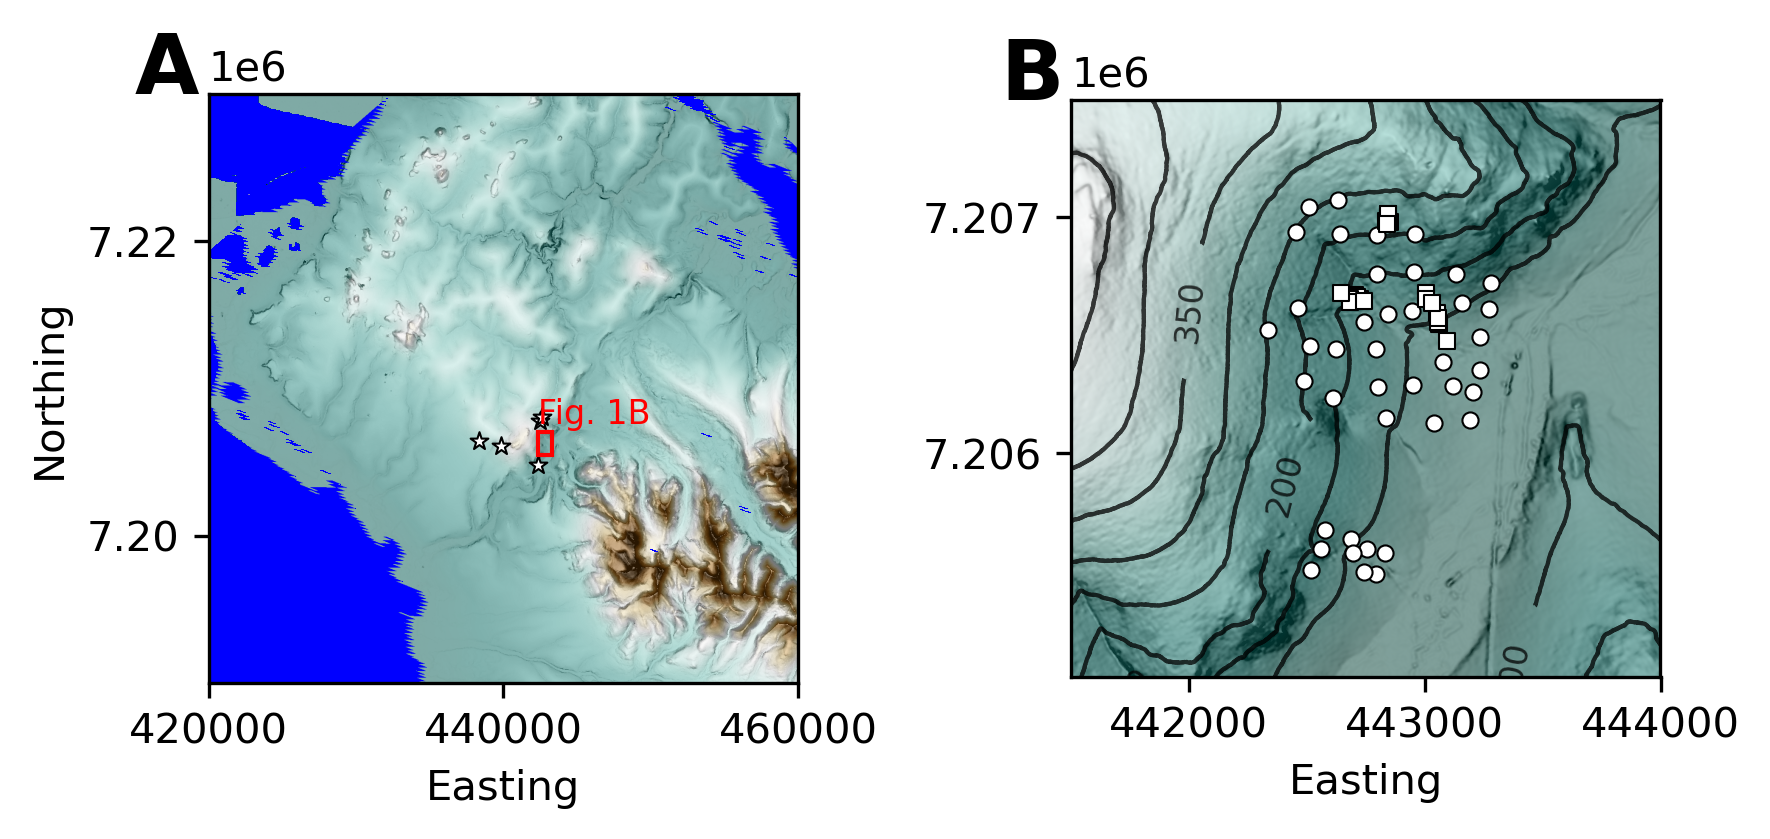

In [10]:
fig, ax = plt.subplots(1,2, figsize=(6,3),dpi=300)

# transform rasterio plot to real world coords
extent_r=[dem.bounds[0], dem.bounds[2], dem.bounds[1], dem.bounds[3]]
extent_t47=[t47_dem.bounds[0], t47_dem.bounds[2], t47_dem.bounds[1], t47_dem.bounds[3]]

im0 = rasterio.plot.show(slope, extent=extent_r,
                         vmin=0.0,
                         vmax=30.0,
                         cmap="Greys",
                         #alpha=0.5,
                         zorder=0,
                         ax=ax[0])
im1 = rasterio.plot.show(dem, extent=extent_r,
                         cmap="BrBG_r",
                         ax=ax[0],
                         vmax=(np.nanmax(dem.read(1))*0.67), # % of highest elev. non-nan
                         alpha=0.5,
                        zorder=1)

water.plot(color='b',ax=ax[0])

insar_pts.plot(ax=ax[0],
               marker='*',
               edgecolor='k',
               color='w',
               markersize=20,
               linewidth=0.5,
              )

box = matplotlib.patches.Rectangle(box_params[0],
                                   width = box_params[1],
                                   height = box_params[2],
                                   edgecolor='r',
                                   facecolor='none')

ax[0].add_patch(box)


im0 = rasterio.plot.show(t47_slope, extent=extent_t47,
                         vmin=0.0,
                         vmax=30.0,
                         cmap="Greys",
                         #alpha=0.5,
                         zorder=0,
                         ax=ax[1])
im1 = rasterio.plot.show(t47_dem, extent=extent_t47,
                         cmap="BrBG_r",
                         ax=ax[1],
                         vmax=(np.nanmax(dem.read(1))*0.67), # % of highest elev. non-nan
                         alpha=0.5,
                        zorder=1)
im2 = rasterio.plot.show(t47_dem, extent=extent_t47,
                         contour=True,
                         levels=np.arange(0,np.nanmax(dem.read(1)),50),
                         colors=['black'],
                         linewidths=1,
                         contour_label_kws={
                             "colors":"black",
                             "fontsize":8,
                             "inline_spacing":3,
                         #"fmt":"%1.0f"
                         },
                         ax=ax[1],
                         alpha=0.75,
                        zorder=2)

sites_3N[sites_3N['type'] == 'gcp'].plot(marker='o',
                                         edgecolor='k',
                                         color='w',
                                         markersize=15,
                                         linewidth=0.5,
                                         ax=ax[1],
                                        zorder=3)
sites_3N[sites_3N['type'] == 'lobe'].plot(marker='s',
                                         edgecolor='k',
                                         color='w',
                                         markersize=15,
                                         linewidth=0.5,
                                          ax=ax[1],
                                         zorder=3)

ax[0].set_ylim((7.19e6, 7.23e6))
ax[0].set_xlim((4.2e5, 4.6e5))
ax[0].locator_params(axis='x', nbins=3)
ax[0].locator_params(axis='y', nbins=3)
ax[0].set_xlabel("Easting")
ax[0].set_ylabel("Northing")
ax[0].text(4.2e5-5000, 7.23e6, "A",size=20, weight='bold')
ax[0].text(box_params[0][0], box_params[0][1]+500, "Fig. 1B",color="r",size=8)


ax[1].set_ylim((7.20505e6, 7.2075e6))
ax[1].set_xlim((4.415e5, 4.440e5))
ax[1].locator_params(axis='x', nbins=3)
ax[1].locator_params(axis='y', nbins=3)
ax[1].set_xlabel("Easting")
ax[1].text(4.415e5-300, 7.2075e6, "B",size=20, weight='bold')


ax[0].set_facecolor('b')

fig.tight_layout()

plt.savefig(os.path.join(figure_path, "Fig_1_map.png"), bbox_inches="tight")

## Supplemental figure: InSAR average displacements (while I'm here)

Text(-34.98611111111111, 0.5, 'Northing')

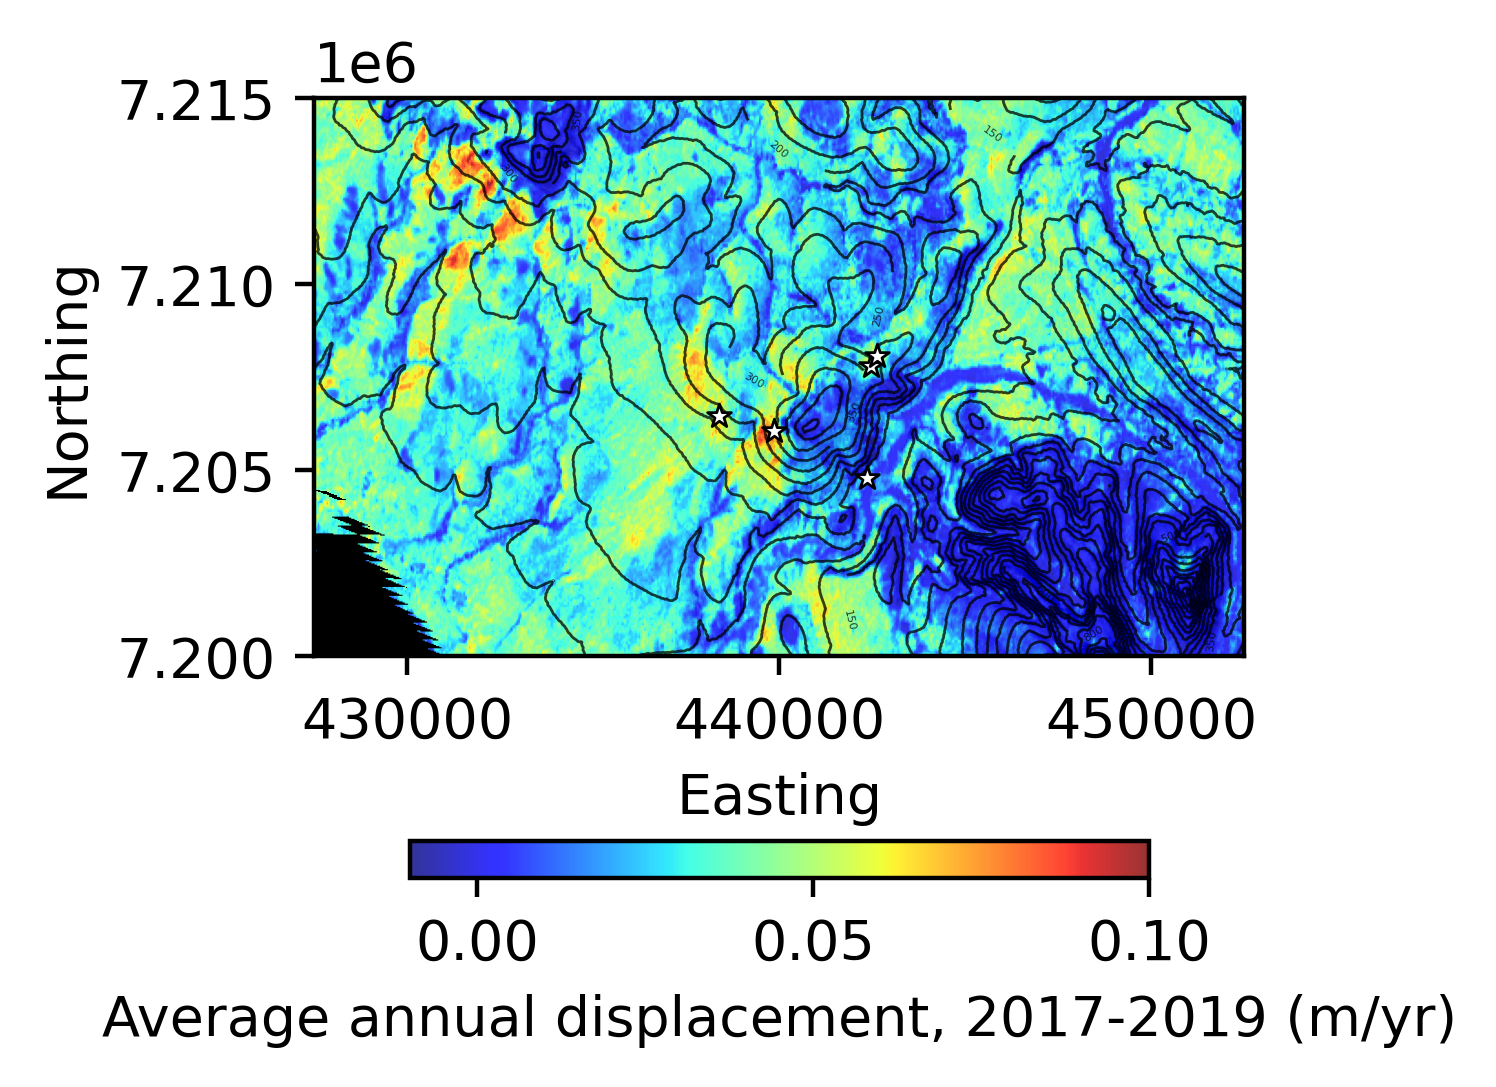

In [11]:
insar_map = rasterio.open(os.path.join(data_path,"Teller_47_Data_InSAR//avg_disp171819_utm.tif"))

fig, ax = plt.subplots(figsize=(3,3),dpi=400)

# transform rasterio plot to real world coords
extent_r=[dem.bounds[0], dem.bounds[2], dem.bounds[1], dem.bounds[3]]
extent_t47=[t47_dem.bounds[0], t47_dem.bounds[2], t47_dem.bounds[1], t47_dem.bounds[3]]

im0 = rasterio.plot.show(slope, extent=extent_r,
                         vmin=0.0,
                         vmax=30.0,
                         cmap="Greys",
                         #alpha=0.5,
                         zorder=1,
                         ax=ax)
im1 = rasterio.plot.show(insar_map, extent=extent_r,
                         cmap="jet",
                         ax=ax,
                         vmin=-0.01,
                         vmax=0.1,
                         alpha=0.8,
                        zorder=2)
# For colorbar
imx = plt.imshow(insar_map.read(1), extent=extent_r,
                         cmap="jet",
                         vmin=-0.01,
                         vmax=0.1,
                         alpha=0.8,
                        zorder=0)

im2 = rasterio.plot.show(dem, extent=extent_r,
                         contour=True,
                         levels=np.arange(0,np.nanmax(dem.read(1)),50),
                         colors=['black'],
                         linewidths=0.5,
                         contour_label_kws={
                             "colors":"black",
                             "fontsize":2,
                             "inline_spacing":1,
                         #"fmt":"%1.0f"
                         },
                         ax=ax,
                         alpha=0.75,
                        zorder=3)

water.plot(color='k',ax=ax, zorder=4)

insar_pts.plot(ax=ax,
               marker='*',
               edgecolor='k',
               color='w',
               markersize=20,
               linewidth=0.5,
               zorder=5
              )

cb = fig.colorbar(imx, ax=ax, label="Average annual displacement, 2017-2019 (m/yr)",  orientation='horizontal', fraction=0.04, pad=0.2)

ax.set_ylim((7.2e6, 7.215e6))
ax.set_xlim((4.275e5, 4.525e5))

ax.locator_params(axis='x', nbins=3)
ax.locator_params(axis='y', nbins=3)
ax.set_xlabel("Easting")
ax.set_ylabel("Northing")

plt.savefig(os.path.join(figure_path, "InSAR_regional.png"), bbox_inches="tight")

# dGPS

## Calculate displacements from annual GPS position data

In [12]:
def distance(x1,x2,y1,y2):
    return (np.absolute((x2-x1)**2 + (y1-y2)**2) ** (1/2))

In [13]:
locs = pd.read_csv(os.path.join(data_path,"Teller_47_Data_dGPS/target_locs_cleaned.csv"))

In [14]:
locs['dDist_1819'] = distance(locs['Easting_2018_y'],locs['Easting_2019_y'],locs['Northing_2018_y'],locs['Northing_2019_y'])
locs['dDist_1718'] = distance(locs['Easting_2017'],locs['Easting_2018_y'],locs['Northing_2017'],locs['Northing_2018_y'])
locs['dDist_1719_avg'] = distance(locs['Easting_2017'],locs['Easting_2019_y'],locs['Northing_2017'],locs['Northing_2019_y'])/2 # Two years of data
locs['dElev_1819'] = locs['Elevation_minus_rebar_m_2019'] - locs['Elevation_2018_y'] 
locs['dElev_1718'] = locs['Elevation_2018_y'] - locs['Elevation_2017'] 
locs['dElev_1719_avg'] = (locs['Elevation_2019_y'] - locs['Elevation_2017']) /2 # Two years of data

locs['slope_normal_1819']=(locs['dDist_1819']**2 + locs['dElev_1819']**2)**(1/2)
locs['slope_normal_1718']=(locs['dDist_1718']**2 + locs['dElev_1718']**2)**(1/2)
locs['slope_normal_1719']=(locs['dDist_1719_avg']**2 + locs['dElev_1719_avg']**2)**(1/2)



locs['position_change_uncertainty'] = np.sqrt((locs['position_uncertainty'] **2) *2)
locs['elevation_change_uncertainty'] = np.sqrt((locs['elevation_uncertainty'] **2) *2)
locs['slope_normal_change_uncertainty'] =np.sqrt((locs['elevation_uncertainty'] **2) + (locs['position_uncertainty'] **2))


In [15]:
locs['elevation_uncertainty']

0     0.031850
1     0.031850
2     0.031850
3     0.031850
4     0.031850
        ...   
60    0.015925
61    0.015925
62    0.015925
63    0.015925
64    0.015925
Name: elevation_uncertainty, Length: 65, dtype: float64

In [16]:
locs.to_csv("locs.csv")

In [17]:
# Turn dataframe into geodataframe

geometry = [Point(xy) for xy in zip(locs['Easting_2019_y'], locs['Northing_2019_y'])]
sites_3N = gpd.GeoDataFrame(locs, crs="EPSG:32603", geometry=geometry)

## Make Figure 3 displacement map

In [18]:
pos_change = sites_3N[sites_3N['dElev_1819'] > 0]
neg_change = sites_3N[sites_3N['dElev_1819'] < 0]

Text(0.5, 52.746212121212125, 'Easting (m)')

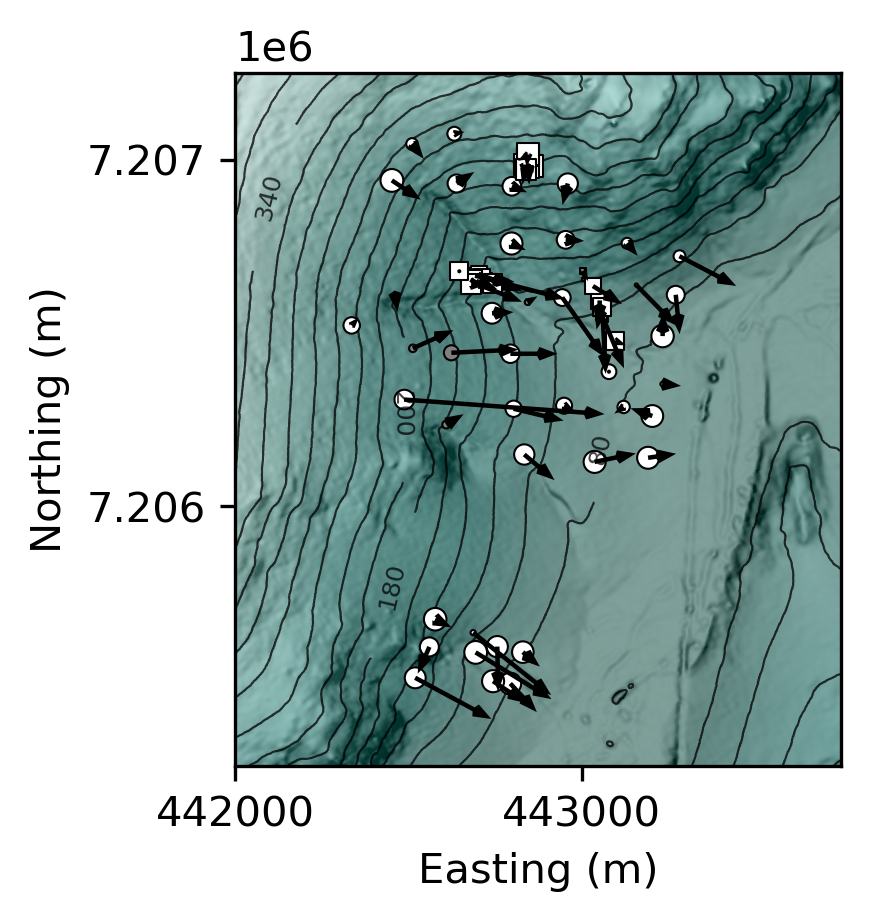

In [19]:
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
im0 = rasterio.plot.show(t47_slope, extent=extent_t47,
                         vmin=0.0,
                         vmax=30.0,
                         cmap="Greys",
                         #alpha=0.5,
                         zorder=0,
                         ax=ax)
im1 = rasterio.plot.show(t47_dem, extent=extent_t47,
                         cmap="BrBG_r",
                         ax=ax,
                         vmax=(np.nanmax(dem.read(1))*0.67), # % of highest elev. non-nan
                         alpha=0.5,
                        zorder=1)
im2 = rasterio.plot.show(t47_dem, extent=extent_t47,
                         contour=True,
                         levels=np.arange(0,np.nanmax(dem.read(1)),20),
                         colors=['black'],
                         linewidths=0.5,
                         contour_label_kws={
                             "colors":"black",
                             "fontsize":6,
                             "inline_spacing":3,
                         #"fmt":"%1.0f"
                         },
                         ax=ax,
                         alpha=0.75,
                        zorder=2)

pos_change[pos_change['type'] == 'gcp'].plot(marker='o',
                                         edgecolor='k',
                                         color='gray',
                                         markersize=(pos_change['dElev_1819']+abs(pos_change['dElev_1819'].min()))*100,
                                         linewidth=0.5,
                                         ax=ax,
                                        zorder=3)
# sites_3N[sites_3N['type'] == 'lobe'].plot(marker='s',
#                                          edgecolor='k',
#                                          color='w',
#                                          markersize=(sites_3N['dElev_1819']+abs(sites_3N['dElev_1819'].min()))*100,
#                                          linewidth=0.5,
#                                           ax=ax,
#                                          zorder=3)

pos_change[pos_change['type'] == 'lobe'].plot(marker='s',
                                         edgecolor='k',
                                         color='gray',
                                         markersize=(pos_change['dElev_1819']+abs(pos_change['dElev_1819'].min()))*100,
                                         linewidth=0.5,
                                          ax=ax,
                                         zorder=3)

neg_change[neg_change['type'] == 'gcp'].plot(marker='o',
                                         edgecolor='k',
                                         color='w',
                                         markersize=(neg_change['dElev_1819']+abs(neg_change['dElev_1819'].min()))*100,
                                         linewidth=0.5,
                                         ax=ax,
                                        zorder=3)

neg_change[neg_change['type'] == 'lobe'].plot(marker='s',
                                         edgecolor='k',
                                         color='w',
                                         markersize=(neg_change['dElev_1819']+abs(neg_change['dElev_1819'].min()))*100,
                                         linewidth=0.5,
                                          ax=ax,
                                         zorder=3)
X = locs['Easting_2018_y'].values
Y = locs['Northing_2018_y'].values
U = locs['Easting_2019_y']-locs['Easting_2018_y'].values
V = locs['Northing_2019_y']-locs['Northing_2018_y'].values
ax.quiver(X,Y, U, V,
          headwidth=3,
          headlength=4,
          zorder=4)




ax.set_ylim((7.20525e6, 7.20725e6))
ax.set_xlim((4.42e5, 4.4375e5))
ax.locator_params(axis='x', nbins=3)
ax.locator_params(axis='y', nbins=3)
ax.set_ylabel("Northing (m)")
ax.set_xlabel("Easting (m)")


plt.savefig(os.path.join(figure_path, "Fig_3_vector_map_all.png"), bbox_inches="tight")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 52.746212121212125, 'Easting (m)')

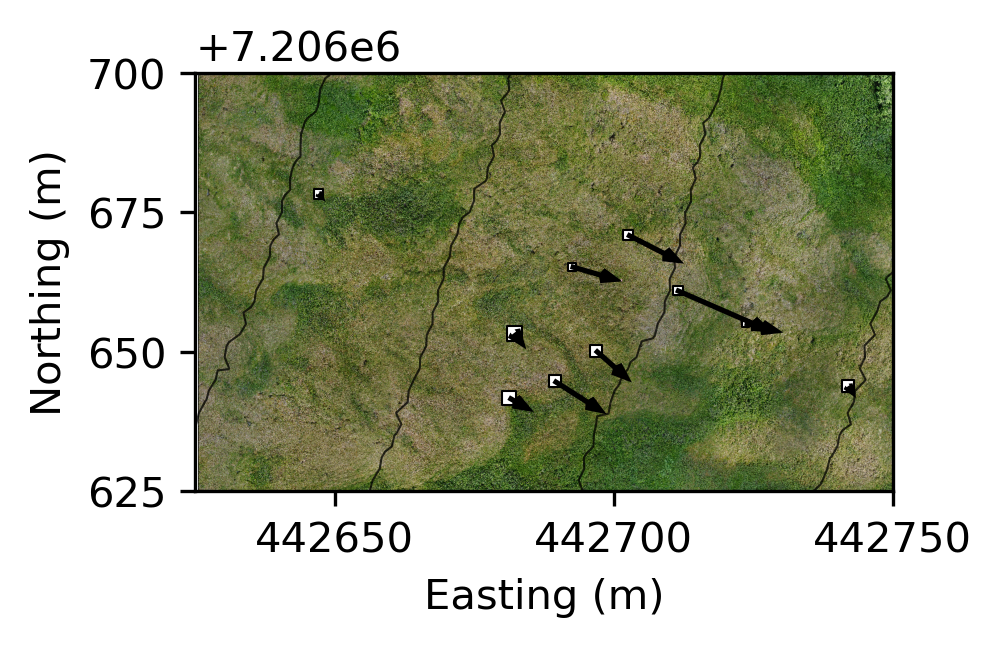

In [20]:
lobe = rasterio.open(os.path.join(data_path,"Teller_47_Data_Rasters//t47_lobe_clip_fig3.tif"))

fig, ax = plt.subplots(figsize=(3,3), dpi=300)

im0 = rasterio.plot.show(lobe.read([1,2,3]),
                        extent=[lobe.bounds[0], lobe.bounds[2], lobe.bounds[1], lobe.bounds[3]],
                         # vmin=0.0,
                         # vmax=30.0,
                         # cmap="Greys",
                         # #alpha=0.5,
                         zorder=0,
                         ax=ax)
im2 = rasterio.plot.show(t47_dem, extent=extent_t47,
                         contour=True,
                         levels=np.arange(0,np.nanmax(dem.read(1)),10),
                         colors=['black'],
                         linewidths=0.5,
                         contour_label_kws={
                             "colors":"black",
                             "fontsize":6,
                             "inline_spacing":3,
                         #"fmt":"%1.0f"
                         },
                         ax=ax,
                         alpha=0.75,
                        zorder=2)
sites_3N[sites_3N['type'] == 'lobe'].plot(marker='s',
                                         edgecolor='k',
                                         color='w',
                                         markersize=(sites_3N['dElev_1719_avg']+abs(sites_3N['dElev_1719_avg'].min()))*100,
                                         linewidth=0.5,
                                          ax=ax,
                                         zorder=3)
X = locs['Easting_2017'].values
Y = locs['Northing_2017'].values
U = (locs['Easting_2019_y']-locs['Easting_2017'].values)/2
V = (locs['Northing_2019_y']-locs['Northing_2017'].values)/2
ax.quiver(X,Y, U, V,
          headwidth=3,
          headlength=4,
          zorder=4)
ax.set_ylim((7.206625e6, 7.2067e6))
ax.set_xlim((4.42625e5, 4.4275e5))
ax.locator_params(axis='x', nbins=3)
ax.locator_params(axis='y', nbins=3)
ax.set_ylabel("Northing (m)")
ax.set_xlabel("Easting (m)")

plt.savefig(os.path.join(figure_path, "Fig_3_vector_map_lobe.png"), bbox_inches="tight")

## Sample topographic rasters at GPS points

In [21]:
stack = ["t47_slope.tif", "t47_acc.tif", "t47_radiation.tif"]
stack_names = ["slope", "flow_acc", "radiation"]

coords = [(x,y) for x, y in zip(locs['Easting_2019_y'], locs['Northing_2019_y'])]         
         
for i, raster_file in enumerate(stack):
    # Sample the raster at every point location and store values in DataFrame
    src = rasterio.open((os.path.join(data_path, "Teller_47_Data_Rasters", raster_file)))
    col = stack_names[i]
    print(col)
    locs[col] = [x[0] for x in src.sample(coords)]

#https://geopandas.org/en/stable/gallery/geopandas_rasterio_sample.html

slope
flow_acc
radiation


## Make boxplots and scatterplots

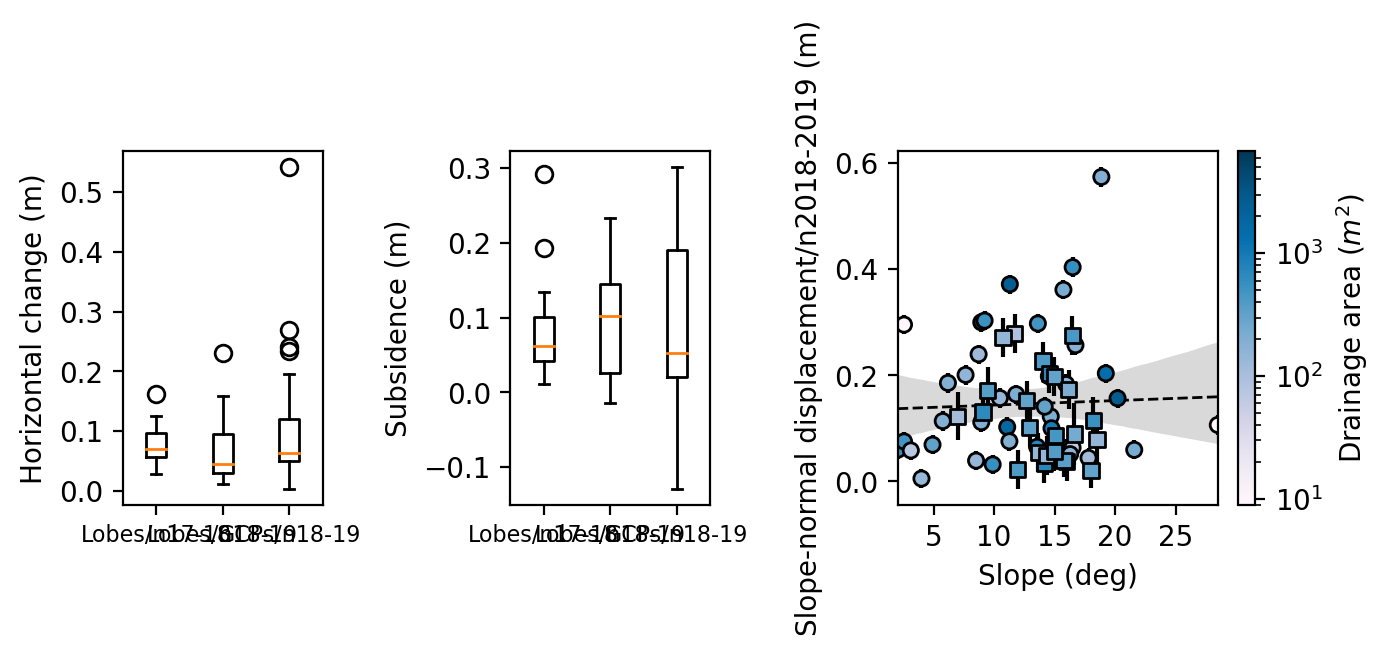

In [22]:
elevation_change = [(locs['dElev_1718'].dropna())* -1,
                    (locs[locs['type']=='lobe']['dElev_1819'])* -1,
                   (locs[locs['type']=='gcp']['dElev_1819'])* -1]  #Changing sign convention so that subsidence is positive

position_change = [locs['dDist_1718'].dropna(),
                    locs[locs['type']=='lobe']['dDist_1819'],
                   locs[locs['type']=='gcp']['dDist_1819']]

fig, ax = plt.subplots(1,3, figsize=(7,2.5), dpi=200,
                     gridspec_kw={'width_ratios':[1, 1, 2]}
                      )
ax[0].boxplot(position_change)
ax[0].set_xticklabels(['Lobes/n17-18', 'Lobes/n18-19','GCPs/n18-19'], fontsize=8)

ax[1].boxplot(elevation_change)
ax[1].set_xticklabels(['Lobes/n17-18', 'Lobes/n18-19','GCPs/n18-19'], fontsize=8)

regression = sns.regplot(x='slope', y='slope_normal_1819',
                         scatter=False,
                        data=locs,
                         line_kws={"color": "black",
                                  "lw":1,
                                  'linestyle':'--'},
                        ax=ax[2],
                        )

markers={"gcp":"o","lobe":"s"}
for typ in markers:
    d = locs[locs['type']==typ]

    

    im = ax[2].scatter(d['slope'], d['slope_normal_1819'], 
                s = 30, 
                c = d['flow_acc'], 
                cmap='PuBu',
               norm=colors.LogNorm(
               vmin=locs['flow_acc'].min(),
               vmax=locs['flow_acc'].max(),
               ),
                marker = markers[typ],
                edgecolor='k',
                       zorder=2
               #ax=ax[2]
                 )
    ime = ax[2].errorbar(d['slope'], d['slope_normal_1819'], 
                         yerr=d['slope_normal_change_uncertainty'],
                         fmt="o",
                         ls='none',
                         markersize=1,
                         c='k',
               # s = 30, 
               #  c = d['flow_acc'], 
               #  cmap='PuBu',
               # norm=colors.LogNorm(
               # vmin=locs['flow_acc'].min(),
               # vmax=locs['flow_acc'].max(),
               # ),
               #  marker = markers[typ],
               #  edgecolor='k',
               # ax=ax[2]
                         zorder=1
                 )
cb = fig.colorbar(im, ax=ax[2], label="Drainage area ($m^2$)")


# ax[2].scatter(x=all_displacements['slope'],y=all_displacements['combined'],
#               c=all_displacements['flowacc'],
#               cmap='PuBu',
#               norm=colors.LogNorm(),
#               column=[all_displacements['type']],
#               edgecolor='black',
#               s=50)


ax[0].set_ylabel('Horizontal change (m)')
ax[1].set_ylabel('Subsidence (m)')

ax[2].set_ylabel('Slope-normal displacement/n2018-2019 (m)')
ax[2].set_xlabel('Slope (deg)')

ax[2].locator_params(axis='x', nbins=6)

fig.tight_layout()
plt.savefig(os.path.join(figure_path, "Fig_3_boxes_scatter.png"), bbox_inches="tight")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lobe vs. gcp: t-test independent samples, P_val:1.149e-01 t=-1.599e+00


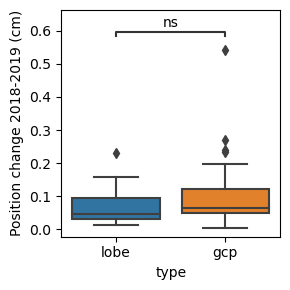

In [47]:
# Statistical significance?

from statannotations.Annotator import Annotator

fig, ax = plt.subplots(figsize=(3,3))

x = "type"
y1 = "dDist_1819"
order = ["lobe","gcp"]
ax = sns.boxplot(data=locs, x=x, y=y1, order=order)              
annotator = Annotator(ax, [("lobe","gcp")], data=locs, x=x, y=y)
annotator.configure(test='t-test_ind', text_format='star', loc='inside')
annotator.apply_and_annotate()

ax.set_ylabel("Position change 2018-2019 (cm)")
fig.tight_layout()

plt.savefig(os.path.join(figure_path, "ttest_1.png"), bbox_inches="tight")

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

lobe vs. gcp: t-test independent samples, P_val:1.149e-01 t=-1.599e+00


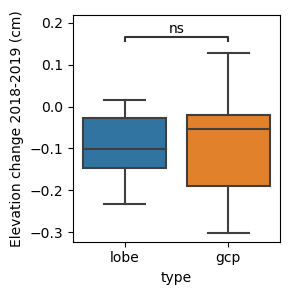

In [46]:
fig, ax = plt.subplots(figsize=(3,3))

x = "type"
y2 = "dElev_1819"
order = ["lobe","gcp"]
ax = sns.boxplot(data=locs, x=x, y=y2, order=order)              
annotator = Annotator(ax, [("lobe","gcp")], data=locs, x=x, y=y)
annotator.configure(test='t-test_ind', text_format='star', loc='inside')
annotator.apply_and_annotate()

ax.set_ylabel("Elevation change 2018-2019 (cm)")
fig.tight_layout()
plt.savefig(os.path.join(figure_path, "ttest_2.png"), bbox_inches="tight")

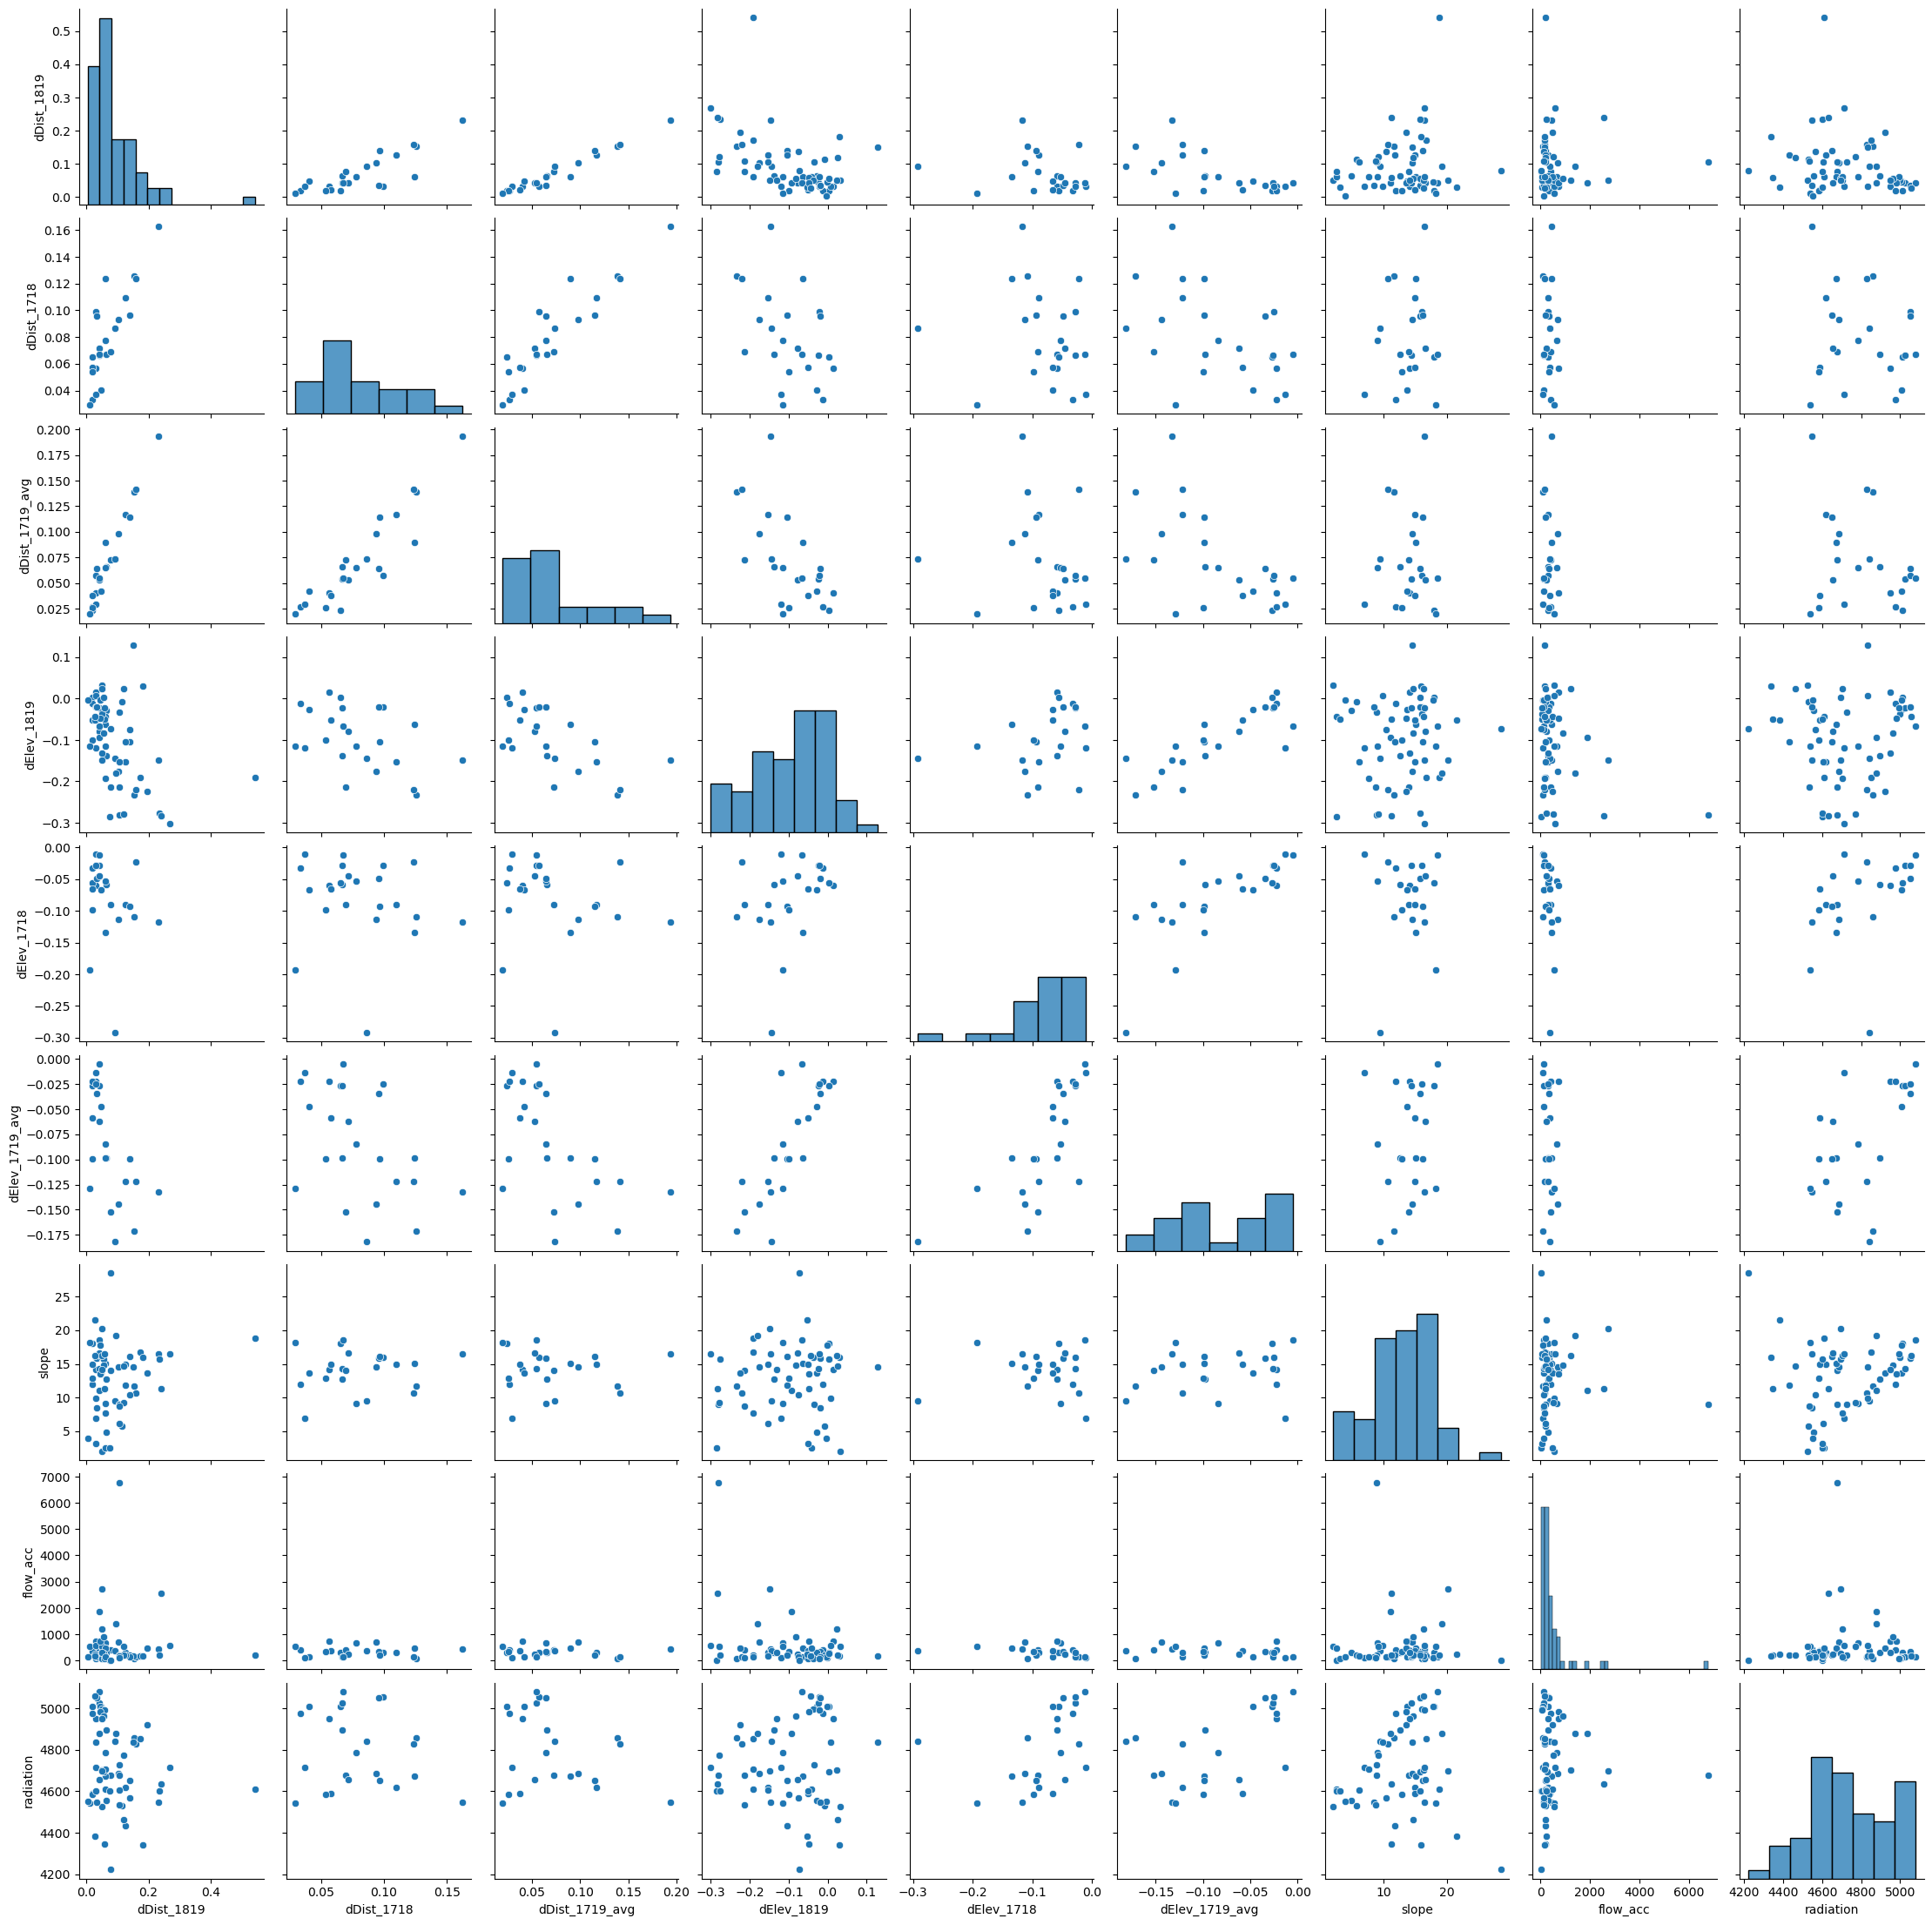

In [23]:
pairplot_df = locs.loc[:, ['dDist_1819','dDist_1718','dDist_1719_avg','dElev_1819','dElev_1718','dElev_1719_avg','slope','flow_acc','radiation']]
im = sns.pairplot(pairplot_df)
im.savefig(os.path.join(figure_path, "gps_pairplot.png"), bbox_inches="tight",dpi=200)

# Insar vs meteo

## Aggregate climate data

In [24]:
calm = pd.read_csv(data_path+"Teller_47_Data_Meteo//CALM_seward.csv",parse_dates=True)

nome = pd.read_csv(data_path+"Teller_47_Data_Meteo//nome_airport_data_all.csv",header=5, parse_dates=True, index_col="Date")#.fillna(0)
# Clean data and only use complete years of data
nome['Year'] = nome.index.year.values.astype(int)
nome['Month'] = nome.index.month.values.astype(int)
nome['doy'] = nome.index.dayofyear.values.astype(int)
nome = nome.loc[nome['Year'].between(1901,2021)]
nome[['Precipitation (in)', 'Snowfall (in)']] = nome[['Precipitation (in)', 'Snowfall (in)']].fillna(0)

nome['Precip_mm'] = nome['Precipitation (in)'] * 25.4
nome['Snow_mm'] = nome['Snowfall (in)'] * 25.4
nome['Temp_Mean_C'] = (nome['Mean Temperature (degF)']-32) * (5/9)
nome['Cum_precip'] = nome.groupby(by="Year")['Precip_mm'].cumsum()
nome['Cum_DDT'] = nome[nome["Temp_Mean_C"] > 0.0].groupby(by="Year")['Temp_Mean_C'].cumcount()
nome['DDT_dif'] = nome.groupby(by="Year")['Cum_DDT'].diff()

# Get day of year of date of max precip
max_precip_doy = nome.groupby(['Year'])["Precip_mm"].idxmax()
#https://stackoverflow.com/questions/64865421/find-max-by-year-and-return-date-on-which-max-occurred-in-pandas-dataframe
max_precip_doy = max_precip_doy.dropna()


## Now just get times when thaw is happening-ish (DDT +1 from previous day)

In [25]:
nome_thaw = nome.loc[nome['DDT_dif'] == 1]

# Get day of year of date of max precip
max_precip_doy_thaw = nome_thaw.groupby(['Year'])["Precip_mm"].idxmax()
#https://stackoverflow.com/questions/64865421/find-max-by-year-and-return-date-on-which-max-occurred-in-pandas-dataframe
max_precip_doy_thaw = max_precip_doy_thaw.dropna()

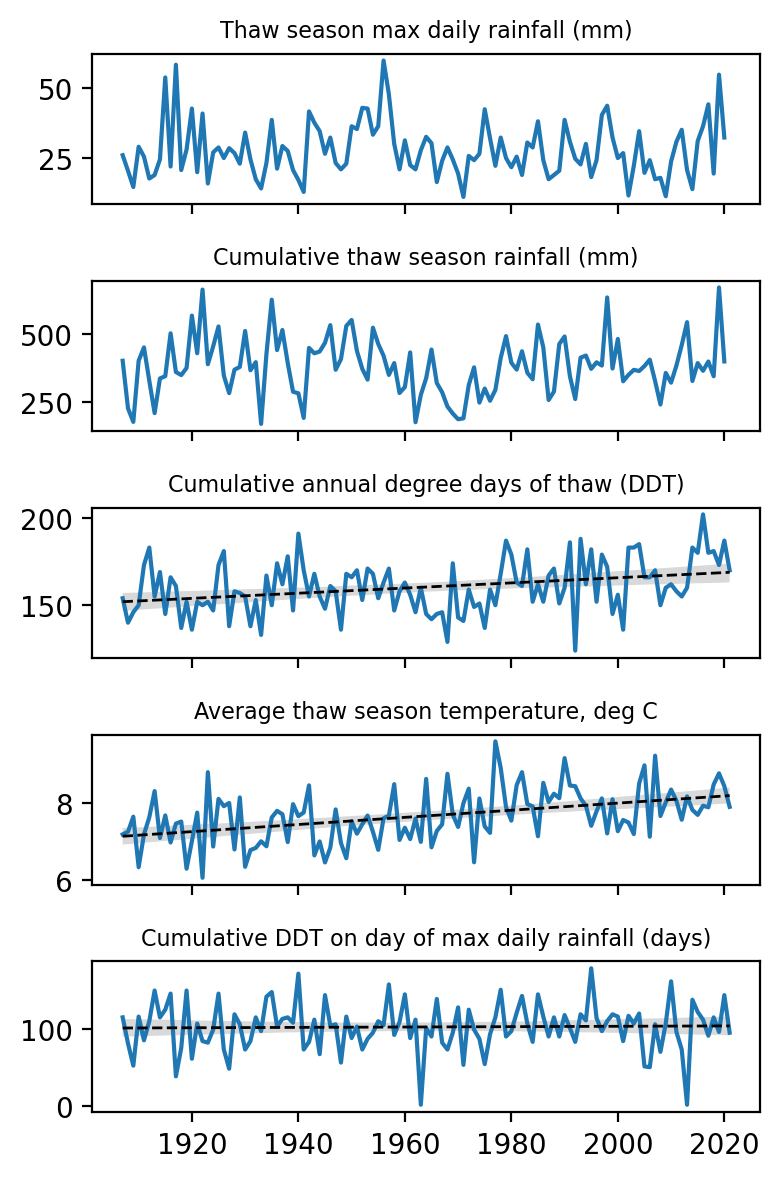

In [26]:
fig, ax = plt.subplots(5,1, figsize=(4,6),
                       sharex=True,
                       tight_layout=True,
                       dpi=200)
# fig = plt.figure(figsize=(8,8), dpi=200)
# ax = {}
# ax[0] = fig.add_subplot(6,1,1)
# ax[1] = fig.add_subplot(6,1,2, sharex=ax[0])
# ax[2] = fig.add_subplot(6,1,3, sharex=ax[0])
# ax[3] = fig.add_subplot(6,1,4, sharex=ax[0])
# ax[4] = fig.add_subplot(6,1,5, sharex=ax[0])
# ax[5] = fig.add_subplot(6,1,6)


ax[0].plot(nome_thaw.groupby(by="Year").max().Precip_mm[:-1])
ax[0].set_title("Thaw season max daily rainfall (mm)", fontsize=8)
ax[1].plot(nome_thaw.groupby(by="Year").max().Cum_precip[:-1])
ax[1].set_title("Cumulative thaw season rainfall (mm)", fontsize=8)


sns.lineplot(x=nome_thaw.groupby(by="Year").mean().index, y=nome_thaw.groupby(by="Year").max().Cum_DDT,ax=ax[2])
sns.regplot(x=nome_thaw.groupby(by="Year").mean().index, y=nome_thaw.groupby(by="Year").max().Cum_DDT, order=1, scatter=False, 
                                     line_kws={"color": "black",
                                  "lw":1,
                                  'linestyle':'--'},
            ax=ax[2])
# ax[2].plot(nome_thaw.groupby(by="Year").max().Cum_DDT[:-1])
ax[2].set_title("Cumulative annual degree days of thaw (DDT)", fontsize=8)
ax[2].set_ylim(120)
ax[2].set_ylabel(None)
# ax[3].plot(nome_thaw.loc[max_precip_doy_thaw, 'Year'], nome_thaw.loc[max_precip_doy_thaw, 'doy'])
# ax[3].set_title("Day of year of max precip event", fontsize=8)
# ax[3].set_ylim((150,320))
sns.lineplot(x=nome_thaw.groupby(by="Year").mean().index, y=nome_thaw.groupby(by="Year").mean()['Temp_Mean_C'],ax=ax[3])
sns.regplot(x=nome_thaw.groupby(by="Year").mean().index, y=nome_thaw.groupby(by="Year").mean()['Temp_Mean_C'], order=1, scatter=False,
                                                 line_kws={"color": "black",
                                  "lw":1,
                                  'linestyle':'--'},
            ax=ax[3])
ax[3].set_ylabel(None)
ax[3].set_title("Average thaw season temperature, deg C", fontsize=8)
# Get cumulative degree days of thaw at time of largest rainstorm
sns.lineplot(x=nome_thaw.loc[max_precip_doy_thaw, 'Year'], y=nome_thaw.loc[max_precip_doy_thaw, 'Cum_DDT'],ax=ax[4])
sns.regplot(x=nome_thaw.loc[max_precip_doy_thaw, 'Year'], y=nome_thaw.loc[max_precip_doy_thaw, 'Cum_DDT'], order=1, scatter=False, 
                                     line_kws={"color": "black",
                                  "lw":1,
                                  'linestyle':'--'},
            ax=ax[4])
ax[4].set_title("Cumulative DDT on day of max daily rainfall (days)", fontsize=8)
ax[4].set_ylabel(None)
ax[4].set_xlabel(None)
fig.tight_layout()
plt.savefig(os.path.join(figure_path, "nome_climate_timeseries_thaw.png"), bbox_inches="tight",dpi=200)

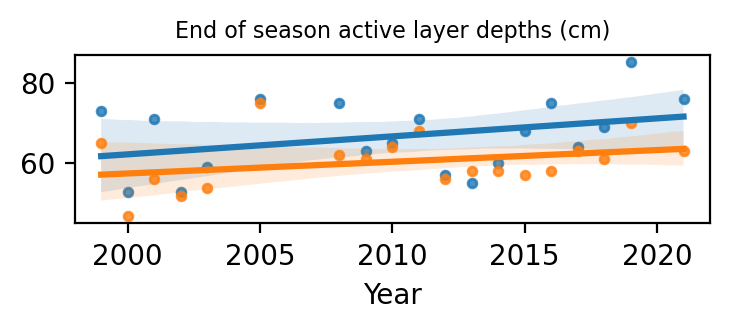

In [27]:
fig, ax = plt.subplots(figsize=(3.75,1.75), sharex=True, dpi=200)
sns.regplot(x=calm['Year'], y=calm['Council_ALT'],ax=ax,scatter_kws={'s':10})
sns.regplot(x=calm['Year'], y=calm['Kougarok_ALT'],ax=ax,scatter_kws={'s':10})
ax.set_title("End of season active layer depths (cm)", fontsize=8)
ax.set_xlim((1998,2022))
ax.set_ylabel(None)


fig.tight_layout()
plt.savefig(os.path.join(figure_path, "calm_vs_climate.png"), bbox_inches="tight",dpi=200)

In [28]:
# Knowing that InSAR data are on a 12 day cycle we can just get 12-day averages/sums
# https://www.statology.org/pandas-moving-average-by-group
nome['C_mean_12day'] = nome.groupby(['Year'])['Temp_Mean_C'].transform(lambda x: x.rolling(12,1).mean())
nome['P_cum_12day'] = nome.groupby(['Year'])['Precip_mm'].transform(lambda x: x.rolling(12,1).sum())

## Aggregate InSAR data

In [29]:
insar_df = pd.read_csv(data_path+"Teller_47_Data_InSAR/insar_site_displacements.csv")
insar_df['year'] = insar_df['year'].astype(int)
insar_df['J1_diff'] = insar_df.groupby(['year'])['J1'].diff()
insar_df['J2_diff'] = insar_df.groupby(['year'])['J2'].diff()
insar_df['J3_diff'] = insar_df.groupby(['year'])['J3'].diff()
insar_df['J4_diff'] = insar_df.groupby(['year'])['J4'].diff()
insar_df['J5_diff'] = insar_df.groupby(['year'])['J5'].diff()

In [30]:
insar_df['site_composite_mean'] = insar_df[['J1','J2','J3','J4','J5']].mean(axis=1)
insar_df['site_composite_std'] = insar_df[['J1','J2','J3','J4','J5']].std(axis=1)
insar_df['std_pos'] = insar_df['site_composite_mean']+insar_df['site_composite_std']
insar_df['std_neg'] = insar_df['site_composite_mean']-insar_df['site_composite_std']

insar_df['diff_composite_mean'] = insar_df[['J1_diff','J2_diff','J3_diff','J4_diff','J5_diff']].mean(axis=1)
insar_df['diff_composite_std'] = insar_df[['J1_diff','J2_diff','J3_diff','J4_diff','J5_diff']].std(axis=1)


In [31]:
insar_df['Date'] = pd.to_datetime(insar_df['year'] *1000 + insar_df['doy'], format='%Y%j')
insar_df['Date'] = pd.to_datetime(insar_df['Date'], format='%Y-%m-%d')
# originally format='%Y%j'
insar_df.set_index('Date', inplace=True)
insar_df.drop('doy', axis=1, inplace=True)

In [32]:
insar_meteo_combined = pd.merge(nome, insar_df, how="outer",right_index=True, left_index=True,
                                #on="Date"
                               )

## Plot climate vs InSAR

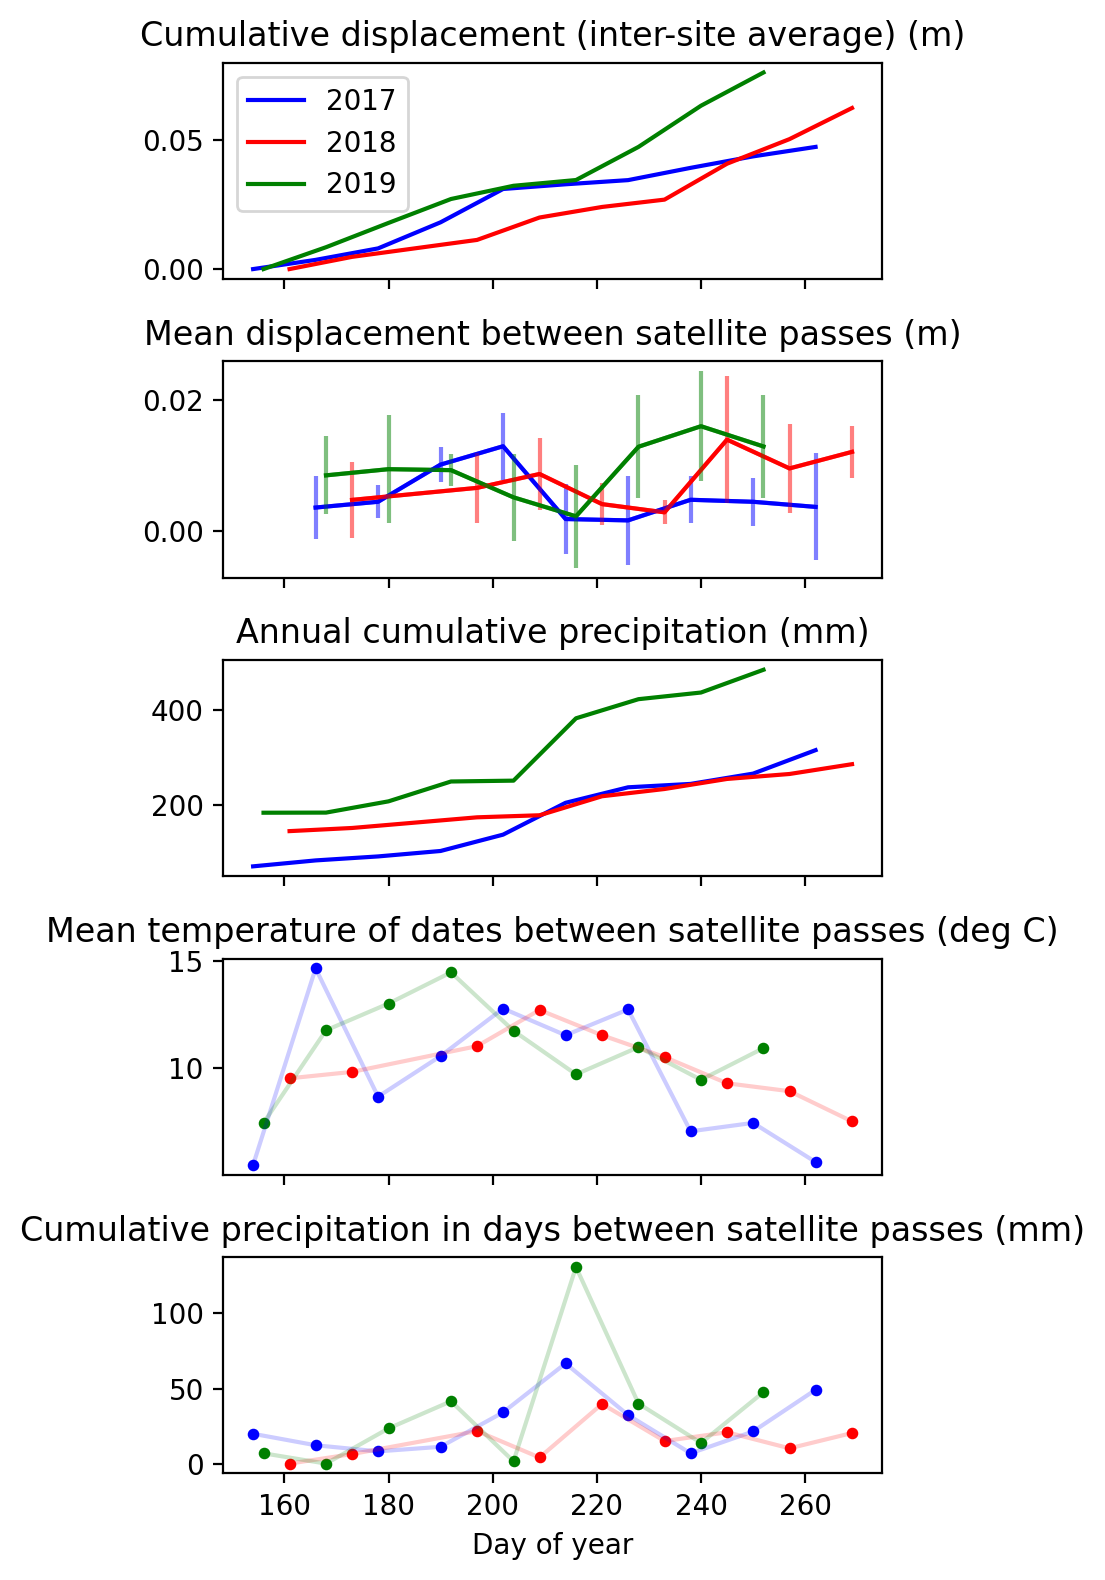

In [33]:
colorlist = ['b','r','g']
years = ["2017","2018","2019"]

fig, ax = plt.subplots(5,1, figsize=(4,8), dpi=200, sharex=True)

for i, (year, group) in enumerate(insar_meteo_combined.groupby(by='year')):
    ax[0].plot(group['doy'], group['site_composite_mean'], c=colorlist[i], label=years[i])
    ax[0].set_title("Cumulative displacement (inter-site average) (m)")
    ax[0].legend()
    ax[1].plot(group['doy'], group['diff_composite_mean'], c=colorlist[i])
    ax[1].set_title("Mean displacement between satellite passes (m)")
    ax[1].errorbar(group['doy'], group['diff_composite_mean'], yerr=group['diff_composite_std'], alpha=.5, c=colorlist[i])
    ax[2].plot(group['doy'], group['Cum_precip'], c=colorlist[i])
    ax[2].set_title("Annual cumulative precipitation (mm)")
    ax[3].scatter(group['doy'], group['C_mean_12day'], c=colorlist[i], s=10)
    ax[3].plot(group['doy'], group['C_mean_12day'], c=colorlist[i], alpha=0.2)
    ax[3].set_title("Mean temperature of dates between satellite passes (deg C)")
    ax[4].scatter(group['doy'], group['P_cum_12day'], c=colorlist[i], s=10)
    ax[4].plot(group['doy'], group['P_cum_12day'], c=colorlist[i], alpha=0.2)
    ax[4].set_title("Cumulative precipitation in days between satellite passes (mm)")
    ax[4].set_xlabel("Day of year")
    #ax.errorbar(group['doy'], group['site_composite_mean'], yerr=group['site_composite_mean']+group['diff_composite_std'])
fig.tight_layout()
plt.savefig(os.path.join(figure_path, "insar_vs_meteo.png"), bbox_inches="tight",dpi=200)

## Bonus figures!

Text(0, 0.5, 'movement between sat passes')

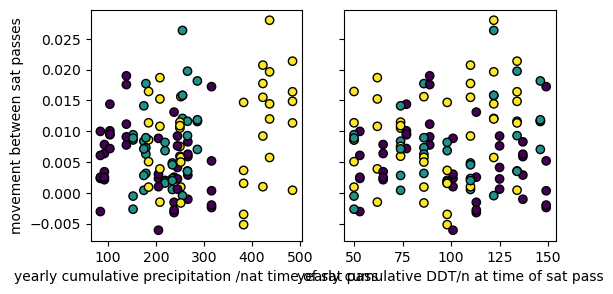

In [34]:
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=100, sharey=True)
for i, site in enumerate(['J1_diff','J2_diff','J3_diff','J4_diff','J5_diff']):
    im = ax[0].scatter(insar_meteo_combined['Cum_precip'],insar_meteo_combined[site],c=insar_meteo_combined['year'],cmap='viridis',edgecolor='k')
    im2 = ax[1].scatter(insar_meteo_combined['Cum_DDT'],insar_meteo_combined[site],c=insar_meteo_combined['year'],cmap='viridis',edgecolor='k')
ax[0].set_xlabel("yearly cumulative precipitation /nat time of sat pass")
ax[1].set_xlabel("yearly cumulative DDT/n at time of sat pass")
ax[0].set_ylabel("movement between sat passes")

Text(0, 0.5, 'movement between sat passes')

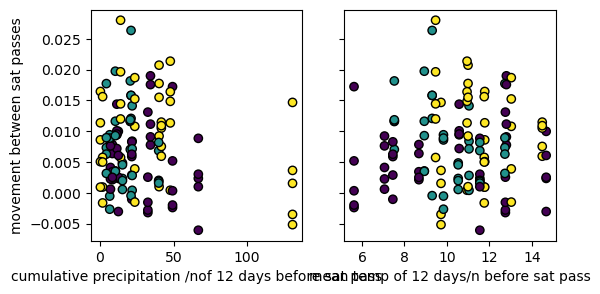

In [35]:
fig, ax = plt.subplots(1,2, figsize=(6,3), dpi=100, sharey=True)
for i, site in enumerate(['J1_diff','J2_diff','J3_diff','J4_diff','J5_diff']):
    im = ax[0].scatter(insar_meteo_combined['P_cum_12day'],insar_meteo_combined[site],c=insar_meteo_combined['year'],cmap='viridis',edgecolor='k')
    im2 = ax[1].scatter(insar_meteo_combined['C_mean_12day'],insar_meteo_combined[site],c=insar_meteo_combined['year'],cmap='viridis',edgecolor='k')
ax[0].set_xlabel("cumulative precipitation /nof 12 days before sat pass")
ax[1].set_xlabel("mean temp of 12 days/n before sat pass")
ax[0].set_ylabel("movement between sat passes")

# Slope stability - modeled vs observed

[SHALSTAB model of Montgomery and Dietrich (1994)](https://agupubs.onlinelibrary.wiley.com/doi/pdfdirect/10.1029/93WR02979?casa_token=vJQ2NGNS82oAAAAA:obDGuoYXpnRkNKJfjXDhhWeQpUtJEy79XBb_eaRFalD2iSjzrXz5JUh_5_1y91WT1Qn3INazspBQllc) and constants to compare against [Mithan et al 2020](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL092264?casa_token=KJynib3aO6kAAAAA%3AxN8ZEirJAHu_58RXNywm_r2wlYQtc0i44WpvXrCJDgA3Rimlc_7NleBwcRR5CDDJ3WqrpYq3xhZq8g) 

## SHALSTAB model

### Load rasters

In [36]:
slope = rasterio.open("new_slope_2m.tif", masked=True)
slope_data=slope.read(1)
slope_data[slope_data < 0.0] =np.nan
drainage_area = rasterio.open(data_path+'Teller_47_Data_Rasters//t47_acc.tif', masked=True)
a = drainage_area.read(1).astype(np.float32)
a[a < 0.0] =np.nan
a[a == 0.0] =1e-7

### SHALSTAB constants and calculations

In [37]:
slope_normal_soil_thickness = np.cos(np.radians(slope_data))

 #flow accumulation [m^2] (flow acc currently in pixels,
#would mutliply by 2 for drainage area in m2 since 2m DEM but since
#'b' is length of countour also 2 m, they cancel out)

q_aug = .05; #[m/day] rain Aug 2 2020
z = 1; #active layer thickness, [m]
tanphi = .84; # original; tan (40 degrees) internal angle of friction
s_w_dens = 2; #ratio of density of saturated soil to water 
Ksat_maybe = 2.2; #m/day if 1/3 is organic and 2/3 is mineral 

##For reference, Mithan et al used:
# tanphi = 0.48 (for 26 degrees) and tanphi=0.32 (for 18 degrees), Harris and Lewkowicz (2000). 
# s_w_dens = 1.88 (H and L)
# z=1.5 (Harris et al. 2008)
#Ksat = 9 E-4 to 9 E-1 (Anderson and Anderson)

q_T = q_aug / (Ksat_maybe * z * np.cos(np.radians(slope_data)))

W = q_aug * a * (Ksat_maybe * z * np.cos(np.radians(slope_data))) * np.sin(np.radians(slope_data))

q_cr_T = ((np.sin(np.radians(slope_data)) * (s_w_dens)) / a ) * (1 -  (np.tan(np.radians(slope_data)) / tanphi));
#critical rainfall / transmissivity

q_cr_K = ((np.sin(np.radians(slope_data)) * (s_w_dens)) / a ) * (1 -  (np.tan(np.radians(slope_data)) / tanphi)) * z * slope_normal_soil_thickness;
#critical rainfall / hydraulic conductivity [T = K cos(theta) z]

k_aug_crit = q_aug / ((np.sin(np.radians(slope_data)) * (s_w_dens)) / a )* (1 -  (np.tan(np.radians(slope_data)) / tanphi)) * z * slope_normal_soil_thickness;
#hydraulic conductivity that just crosses failure threshold for Aug 2
#rainfall event

q_cr= ((np.sin(np.radians(slope_data)) * (s_w_dens)) / a ) * (1 -  (np.tan(np.radians(slope_data)) / tanphi)) * z * slope_normal_soil_thickness * Ksat_maybe;

# Make critical rainfall mm for plotting 
q_cr_plot=q_cr*1000

# Make zeros very smol so logarithms work
q_cr_plot[q_cr_plot <= 0.0] = 1E-7

# Make critical rainfall mm for plotting 
q_cr_T_plot=q_cr_T*1000

# Make zeros very smol so logarithms work
q_cr_T_plot[q_cr_T_plot <= 0.0] = 1E-7

# with rasterio.open(data_path+'Teller_47_Data_Rasters//t47_dem.tif') as src:
#     out_meta = src.meta.copy()
#     with rasterio.open("q_cr.tif","w",**out_meta) as dest:
#         dest.write(q_cr_plot,1)
with rasterio.open("new_slope_2m.tif", masked=True) as src:
    out_meta = src.meta.copy()
    with rasterio.open("q_cr.tif","w",**out_meta) as dest:
        dest.write(q_cr_plot,1)

## Get topographic statistics of mapped failures

### Load and clean shapefiles

In [38]:
# footprint_2018 = gpd.read_file(data_path+'Teller_47_Data_Shapefiles//2018UASExtent.shp')
# footprint_2018= footprint_2018.to_crs('epsg:32603')
# footprint_2018["area (m2)"] = footprint_2018['geometry'].area
# footprint_2018.to_file(data_path+'Teller_47_Data_Shapefiles//footprint_2018.shp')

# footprint_2019 = gpd.read_file(data_path+'Teller_47_Data_Shapefiles//TL47_2019_ImageryFootprint.shp')
# footprint_2019= footprint_2019.to_crs('epsg:32603')
# footprint_2019["area (m2)"] = footprint_2019['geometry'].area
# footprint_2019.to_file(data_path+'Teller_47_Data_Shapefiles//footprint_2019.shp')

footprint_2018 = gpd.read_file(data_path+'Teller_47_Data_Shapefiles//footprint_2018.shp')
footprint_2019 = gpd.read_file(data_path+'Teller_47_Data_Shapefiles//footprint_2019.shp')

footprint_all = gpd.GeoDataFrame(pd.concat([footprint_2019, footprint_2018]))
footprint_all.to_file(data_path+'Teller_47_Data_Shapefiles//footprint_all.shp')

### Sample slope and area for every coordinate in the UAS boundaries

#### Resample and clip drainage area raster

In [39]:
dinf_raster = rxr.open_rasterio(data_path+'Teller_47_Data_Rasters//t47_acc.tif', masked=True)

da_clipped = dinf_raster.rio.clip(footprint_all.geometry)

I think this next part is before I became aware of `gdalwarp` `-tr` and `-tap`, oh well

In [40]:
# Get  all coordinates in 2 m dinf raster

(X_c, Y_c) = np.meshgrid(da_clipped.x.values, da_clipped.y.values)

X_c = X_c.reshape((np.prod(X_c.shape),))
Y_c = Y_c.reshape((np.prod(Y_c.shape),))

coords = [(x,y) for x, y in zip(X_c, Y_c)]


In [41]:
# This is for sure an additional obscenely inefficient way of doing this but shrug, it's Friday afternoon 

geometry = [Point(xy) for xy in coords]
points = gpd.GeoDataFrame(coords, crs="EPSG:32603", geometry=geometry)
points_2018 = gpd.sjoin(points, footprint_2018, op='within')
points_2019 = gpd.sjoin(points, footprint_2019, op='within')

coords_2018 = [(x,y) for x,y in zip(points_2018['geometry'].x , points_2018['geometry'].y)]
coords_2019 = [(x,y) for x,y in zip(points_2019['geometry'].x , points_2019['geometry'].y)]

/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/seward/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/dartfs-hpc/rc/home/1/f005dv1/.conda/envs/seward/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


#### Sample slope and area for every coordiante

In [42]:


with fiona.open(data_path+'Teller_47_Data_Shapefiles//footprint_all.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
with rasterio.open('new_slope.tif', masked=True) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open('new_slope_clipped.tif', "w", **out_meta) as dest:
    dest.write(out_image)
    
with fiona.open(data_path+'Teller_47_Data_Shapefiles//footprint_all.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
with rasterio.open(data_path+'Teller_47_Data_Rasters//t47_acc.tif', masked=True) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open(data_path+'Teller_47_Data_Rasters//t47_acc_clipped.tif', "w", **out_meta) as dest:
    dest.write(out_image)

In [43]:
df_points_2018 = pd.DataFrame()
df_points_2019 = pd.DataFrame()

In [44]:
raster = rasterio.open(data_path+'Teller_47_Data_Rasters//t47_acc_clipped.tif', masked=True)
src = raster
df_points_2018['dinf'] = [x[0] for x in src.sample(coords_2018)]
print('done dinf')
raster.close()

raster = rasterio.open('new_slope_clipped.tif', masked=True)
src = raster
df_points_2018['slope'] = [x[0] for x in src.sample(coords_2018)]
raster.close()

done dinf


In [45]:
raster = rasterio.open(data_path+'Teller_47_Data_Rasters//t47_acc_clipped.tif', masked=True)
src = raster
df_points_2019['dinf'] = [x[0] for x in src.sample(coords_2019)]
print('done dinf')
# raster.close()

raster = rasterio.open('new_slope_clipped.tif', masked=True)
src = raster
df_points_2019['slope'] = [x[0] for x in src.sample(coords_2019)]
raster.close()

done dinf


In [46]:
df_points_2018 = df_points_2018[df_points_2018['dinf'] > 0.0]
df_points_2019 = df_points_2019[df_points_2019['dinf'] > 0.0]

### Get mapped failures shapefile and turn them into points. 

In [47]:
polys_2018 = gpd.read_file(data_path+'Teller_47_Data_Shapefiles//poly_failure_TL47_2018_jcr.shp')
polys_2018 = polys_2018.to_crs('epsg:32603')
polys_2018["area (m2)"] = polys_2018['geometry'].area
polys_2019 = gpd.read_file(data_path + 'Teller_47_Data_Shapefiles//2019_Failure_merged_unique.shp')
polys_2019 = polys_2019.to_crs('epsg:32603')
polys_2019["area (m2)"] = polys_2019['geometry'].area

#https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas


### Make heatmaps for 2018 and 2019 failures

So I made a function to do this I guess

In [48]:
# pts = (int) number of bins for slope-area space
# res = (float, can be, i guess) raster resolution
def make_heatmap(polys, slope_raster, area_raster, pts, res):
    
    polys = gpd.read_file(polys)
    polys = polys.to_crs('epsg:32603')
    
    polys["area (m2)"] = polys['geometry'].area
    
    # Do zonal stats
    dinf_stats = zonal_stats(polys, area_raster, all_touched=True)
    slope_stats = zonal_stats(polys, slope_raster, all_touched=True)
    
    df_dinf = pd.DataFrame(dinf_stats).add_prefix('dInf_')
    df_slope = pd.DataFrame(slope_stats).add_prefix('slope_')

    df_stats = pd.merge(df_dinf, df_slope, how='outer', left_index=True, right_index=True)

    df_stats["area (m2)"] = polys['geometry'].area
    
    drops = df_stats.dropna()
    
    # Make heatmap
    # pts is number of spacings in the bins in slope-area space
    slope_array=np.linspace(7,25,num=pts)
    da_array=np.geomspace(1e1,1e4,num=pts)

    df_stats['bin_dinf'] = pd.cut(df_stats['dInf_max'],bins=da_array, labels=range(len(da_array)-1)
                                 )
    df_stats['bin_slope'] = pd.cut(df_stats['slope_max'],bins=slope_array, labels=range(len(slope_array)-1))
                                   
    heatmap_df = df_stats
                                  
    df_out = df_stats.groupby(['bin_slope','bin_dinf'])['area (m2)']

    heatmap_arr = df_out.sum().sort_index().values.reshape(len(slope_array)-1,len(da_array)-1)
    
    heatmap_arr = ma.masked_where((heatmap_arr == 0), heatmap_arr)
    
    return heatmap_arr
    

In [49]:
pts=40
slope_array=np.linspace(7,25,num=pts)
da_array=np.geomspace(1e1,1e4,num=pts)
heatmap_2018 = make_heatmap(data_path+'Teller_47_Data_Shapefiles//poly_failure_TL47_2018_jcr.shp', "new_slope.tif", data_path+'Teller_47_Data_Rasters//t47_acc.tif', 40, 2)
heatmap_2019 = make_heatmap(data_path+'Teller_47_Data_Shapefiles//2019_Failure_merged_unique.shp', "new_slope.tif", data_path+'Teller_47_Data_Rasters//t47_acc.tif', 40, 2)

### Make a heatmap for the points in each years' UAV survey footprint for normalization

In [50]:
df_points_2018['bin_dinf'] = pd.cut(df_points_2018['dinf'],bins=da_array, labels=range(len(da_array)-1)
                             )
df_points_2018['bin_slope'] = pd.cut(df_points_2018['slope'],bins=slope_array, labels=range(len(slope_array)-1)
                              )
df_out_points = df_points_2018.groupby(['bin_slope','bin_dinf'])['slope']
counts = df_out_points.count().sort_index().values.reshape(len(slope_array)-1,len(da_array)-1)
counts = ma.masked_where((counts == 0), counts)
total_area_in_bin_2018 = counts * 2 # counts is pixels, pixel is 2 m^2

# prop_bin_failure_area = arr/total_area_in_bin
# prop_bin_failure_area[prop_bin_failure_area > .25] = 0.25



df_points_2019['bin_dinf'] = pd.cut(df_points_2019['dinf'],bins=da_array, labels=range(len(da_array)-1)
                             )
df_points_2019['bin_slope'] = pd.cut(df_points_2019['slope'],bins=slope_array, labels=range(len(slope_array)-1)
                              )
df_out_points = df_points_2019.groupby(['bin_slope','bin_dinf'])['slope']
counts = df_out_points.count().sort_index().values.reshape(len(slope_array)-1,len(da_array)-1)
counts = ma.masked_where((counts == 0), counts)
total_area_in_bin_2019 = counts * 2 # counts is pixels, pixel is 2 m^2


### Make plot

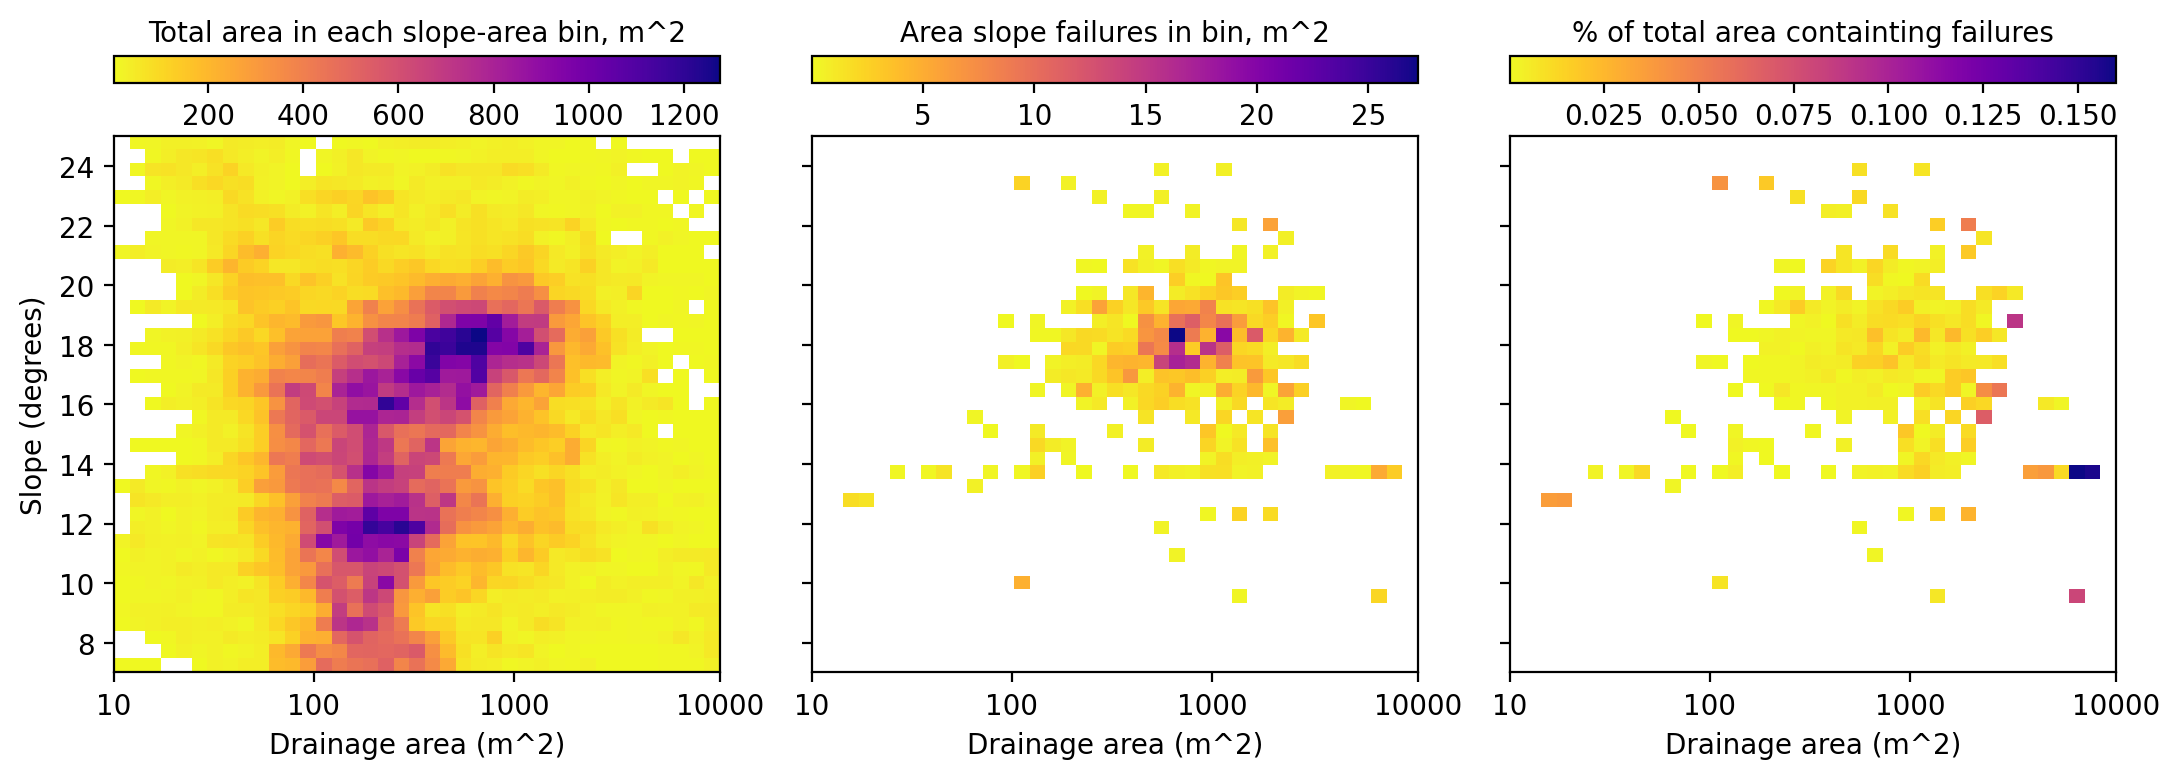

In [51]:
fig, ax = plt.subplots(1,3, figsize=(11,4),dpi=200, sharey=True)

im0 = ax[0].imshow(total_area_in_bin_2018, cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
               origin='lower')

# This is to fake log bins without making the axis truly log
ax[0].set_xticks([0, np.max(da_array)*.33, np.max(da_array)*.66, np.max(da_array)])
ax[0].set_xticklabels([int(da_array[0]), int(round(da_array[int(pts*.33)],0)), int(round(da_array[int(pts*.67)],0)), int(da_array[pts-1])])

divider = make_axes_locatable(ax[0])
# Add an axes to the right of the main axes.
cax0 = divider.append_axes("top", size="5%", pad="10%")
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")
cb0.set_label('Total area in each slope-area bin, m^2', labelpad=-40);
ax[0].set_ylabel('Slope (degrees)')
ax[0].set_xlabel('Drainage area (m^2)')

im1 = ax[1].imshow(heatmap_2018, cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
               origin='lower')

ax[1].set_xticks([0, np.max(da_array)*.33, np.max(da_array)*.66, np.max(da_array)])
ax[1].set_xticklabels([int(da_array[0]), int(round(da_array[int(pts*.33)],0)), int(round(da_array[int(pts*.67)],0)), int(da_array[pts-1])])

divider = make_axes_locatable(ax[1])
# Add an axes to the right of the main axes.
cax1 = divider.append_axes("top", size="5%", pad="10%")
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal")
cb1.set_label('Area slope failures in bin, m^2', labelpad=-40);
ax[1].set_xlabel('Drainage area (m^2)')

im2 = ax[2].imshow((heatmap_2018/total_area_in_bin_2018), cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
               origin='lower')

ax[2].set_xticks([0, np.max(da_array)*.33, np.max(da_array)*.66, np.max(da_array)])
ax[2].set_xticklabels([int(da_array[0]), int(round(da_array[int(pts*.33)],0)), int(round(da_array[int(pts*.67)],0)), int(da_array[pts-1])])

divider = make_axes_locatable(ax[2])
# Add an axes to the right of the main axes.
cax2 = divider.append_axes("top", size="5%", pad="10%")
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal")
cb2.set_label('% of total area containting failures', labelpad=-40);
ax[2].set_xlabel('Drainage area (m^2)')



fig.tight_layout()
plt.savefig(os.path.join(figure_path, "2018_failures_in_slope_area_space.png"), bbox_inches="tight",dpi=200)

In [52]:
fig, ax = plt.subplots(1,3, figsize=(11,4),dpi=200, sharey=True)

im0 = ax[0].imshow(total_area_in_bin_2019, cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
               origin='lower')

# This is to fake log bins without making the axis truly log
ax[0].set_xticks([0, np.max(da_array)*.33, np.max(da_array)*.66, np.max(da_array)])
ax[0].set_xticklabels([int(da_array[0]), int(round(da_array[int(pts*.33)],0)), int(round(da_array[int(pts*.67)],0)), int(da_array[pts-1])])

divider = make_axes_locatable(ax[0])
# Add an axes to the right of the main axes.
cax0 = divider.append_axes("top", size="5%", pad="10%")
cb0 = fig.colorbar(im0, cax=cax0, orientation="horizontal")
cb0.set_label('Total area in each slope-area bin, m^2', labelpad=-40);
ax[0].set_ylabel('Slope (degrees)')
ax[0].set_xlabel('Drainage area (m^2)')

im1 = ax[1].imshow(heatmap_2019, cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
               origin='lower')

ax[1].set_xticks([0, np.max(da_array)*.33, np.max(da_array)*.66, np.max(da_array)])
ax[1].set_xticklabels([int(da_array[0]), int(round(da_array[int(pts*.33)],0)), int(round(da_array[int(pts*.67)],0)), int(da_array[pts-1])])

divider = make_axes_locatable(ax[1])
# Add an axes to the right of the main axes.
cax1 = divider.append_axes("top", size="5%", pad="10%")
cb1 = fig.colorbar(im1, cax=cax1, orientation="horizontal")
cb1.set_label('Area slope failures in bin, m^2', labelpad=-40);
ax[1].set_xlabel('Drainage area (m^2)')

im2 = ax[2].imshow((heatmap_2019/total_area_in_bin_2019), cmap='plasma_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
               origin='lower')

ax[2].set_xticks([0, np.max(da_array)*.33, np.max(da_array)*.66, np.max(da_array)])
ax[2].set_xticklabels([int(da_array[0]), int(round(da_array[int(pts*.33)],0)), int(round(da_array[int(pts*.67)],0)), int(da_array[pts-1])])

divider = make_axes_locatable(ax[2])
# Add an axes to the right of the main axes.
cax2 = divider.append_axes("top", size="5%", pad="10%")
cb2 = fig.colorbar(im2, cax=cax2, orientation="horizontal")
cb2.set_label('% of total area containting failures', labelpad=-40);
ax[2].set_xlabel('Drainage area (m^2)')



fig.tight_layout()
plt.savefig(os.path.join(figure_path, "2019_failures_in_slope_area_space.png"), bbox_inches="tight",dpi=200)

### Steepness vs failure location

In [53]:
xx, yy = np.meshgrid(slope_array[:-1], da_array[:-1])
zz = xx * np.sqrt(yy) #Theodoratos and Kirchner, 2020 and Litwin et al 2021


Text(0.5, 0.98, 'Topographic steepness vs/nfailure location, pre-2019')

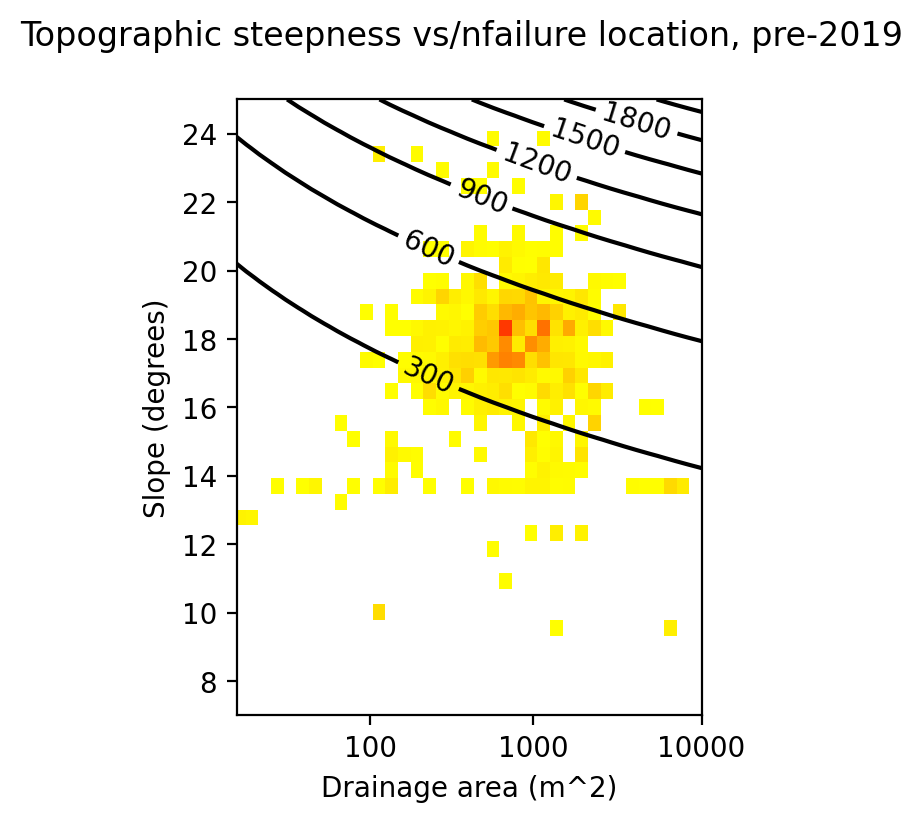

In [54]:
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s}" if plt.rcParams["text.usetex"] else f"{s}"



fig, ax = plt.subplots(figsize=(3,4),dpi=200)
#Y axis is rows in reshape (first value in reshape)



im = ax.imshow(heatmap_2018, cmap='autumn_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
               vmax=35,
#                extent=[0, len(da_array)-1, 0, len(slope_array)-1],
               #                norm=colors.LogNorm(),
               origin='lower')

# im3 = ax.imshow(heatmap_differece, cmap='plasma_r', interpolation='none', aspect='auto',
#                extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
#                origin='lower')


# divider = make_axes_locatable(ax)
# # Add an axes to the right of the main axes.
# cax = divider.append_axes("right", size="5%", pad="2%")
# cb = fig.colorbar(im, cax=cax)
# cb.set_label('Area of failures (m^2)', rotation=270, labelpad=20);
# #ax.set_xscale('log')

CS = ax.contour(zz,extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],colors='k')
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10, colors='k')

ax.set_xticks([0, np.max(da_array)*.33, np.max(da_array)*.66, np.max(da_array)])
ax.set_xticklabels([int(da_array[0]), int(round(da_array[int(pts*.33)],0)), int(round(da_array[int(pts*.67)],0)), int(da_array[pts-1])])

ax.set_xlim(600)
ax.set_ylabel('Slope (degrees)')
ax.set_xlabel('Drainage area (m^2)')

fig.suptitle("Topographic steepness vs/nfailure location, pre-2019",
             y=0.98
            )
plt.savefig(os.path.join(figure_path, "steepness_vs_failures_pre2019.png"), bbox_inches="tight",dpi=300)

Text(0.5, 0.95, 'Topographic steepness vs failure location')

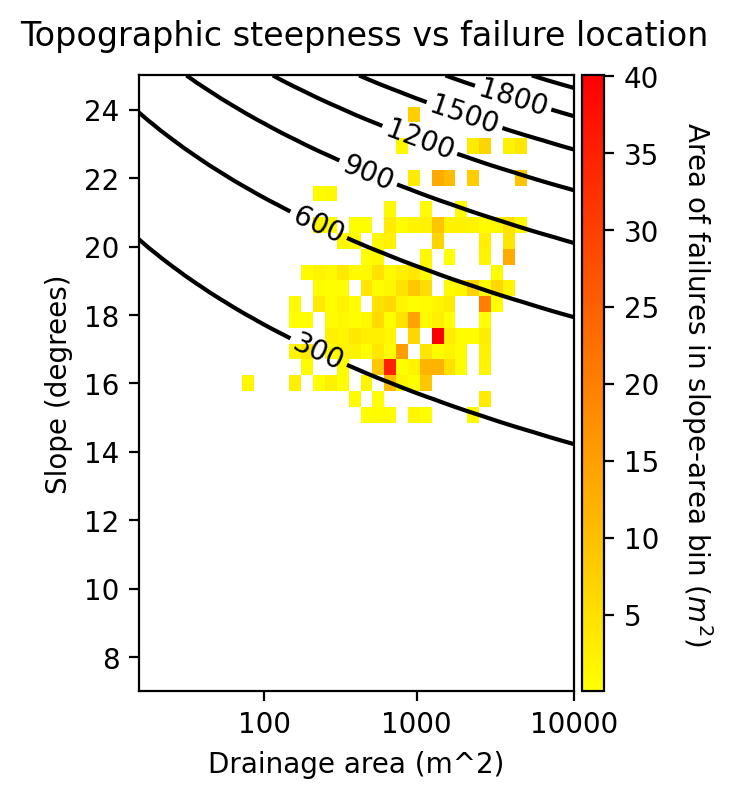

In [55]:
fig, ax = plt.subplots(figsize=(3,4),dpi=200)
#Y axis is rows in reshape (first value in reshape)



im = ax.imshow(heatmap_2019, cmap='autumn_r', interpolation='none', aspect='auto',
               extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
               
#                extent=[0, len(da_array)-1, 0, len(slope_array)-1],
               #                norm=colors.LogNorm(),
               origin='lower')

# im3 = ax.imshow(heatmap_differece, cmap='plasma_r', interpolation='none', aspect='auto',
#                extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],
#                origin='lower')


divider = make_axes_locatable(ax)
# Add an axes to the right of the main axes.
cax = divider.append_axes("right", size="5%", pad="2%")
cb = fig.colorbar(im, cax=cax)
cb.set_label('Area of failures in slope-area bin ($m^2$)', rotation=270, labelpad=20);
#ax.set_xscale('log')

CS = ax.contour(zz,extent=[np.min(da_array), np.max(da_array), np.min(slope_array), np.max(slope_array)],colors='k')
ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10, colors='k')
ax.set_xticks([0, np.max(da_array)*.33, np.max(da_array)*.66, np.max(da_array)])
ax.set_xticklabels([int(da_array[0]), int(round(da_array[int(pts*.33)],0)), int(round(da_array[int(pts*.67)],0)), int(da_array[pts-1])])
ax.set_xlim(600)
ax.set_ylabel('Slope (degrees)')
ax.set_xlabel('Drainage area (m^2)')

fig.suptitle("Topographic steepness vs failure location",
             y=.95
            )
plt.savefig(os.path.join(figure_path, "steepness_vs_failures_proportions"), bbox_inches="tight",dpi=300)

## Make final figure - q_crit and shapefiles

In [56]:
polys_2019['centroid'] = polys_2019.centroid
points_2019 = polys_2019.copy().set_geometry(polys_2019['centroid'])

polys_2018['centroid'] = polys_2018.centroid
points_2018 = polys_2018.copy().set_geometry(polys_2018['centroid'])

with rasterio.open('new_slope.tif', masked=True) as slope:
    extent_slope=[slope.bounds[0], slope.bounds[2], slope.bounds[1], slope.bounds[3]]
# poly_extent = np.asarray(UAS.geometry.total_bounds)[[0,2,1,3]]
# test_bounds = np.asarray(slope.bounds)[[0,2,1,3]]*3

qt_digi = np.digitize((np.log(q_cr_T_plot)), np.array(np.arange(-5.0,5.0,0.5)), right=True)

In [57]:
# Custom colormap for failures

from matplotlib import colors

from matplotlib import cm
viridis = cm.get_cmap('plasma', 8)
newcolors = viridis(np.linspace(0, 1, 7))
withblack = np.vstack(([0.,0.,0.,1.0], newcolors))


# make a color map of fixed colors
cmap = colors.ListedColormap(withblack)
bounds=np.hstack((np.linspace(0,60,7), [61]))
norm = colors.BoundaryNorm(bounds, cmap.N)

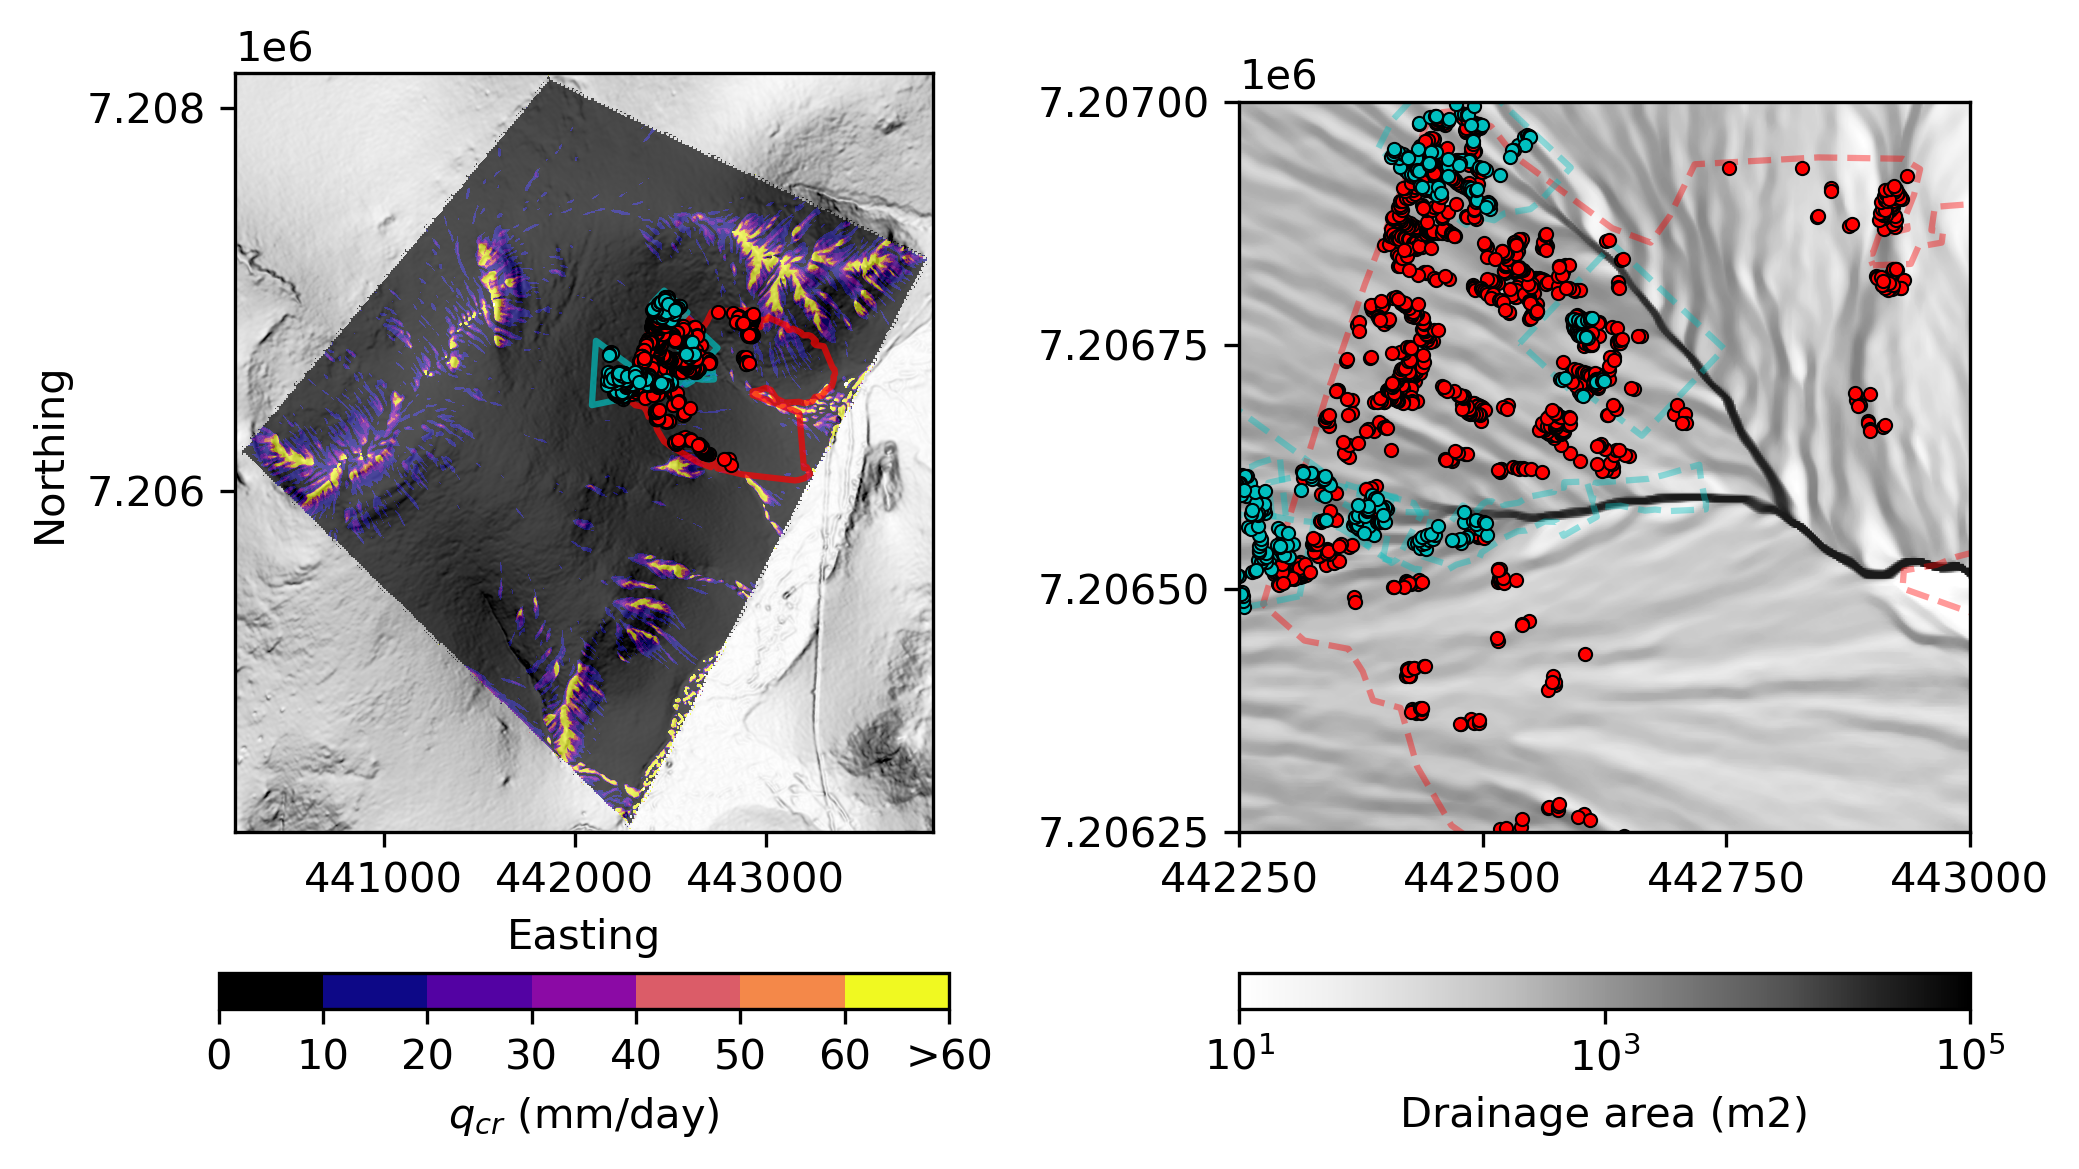

In [58]:

fig, ax = plt.subplots(1,2, figsize=(7,4),dpi=300)
im0 = rasterio.plot.show(t47_slope, extent=extent_slope,
                         vmin=0.0,
                         vmax=30.0,
                         cmap="Greys",
                         #alpha=0.5,
                         zorder=0,
                         ax=ax[0])

with rasterio.open("q_cr.tif", masked=True) as q_cr:      
    qcr_colors = ax[0].imshow(q_cr.read(1),
                             cmap=cmap, 
                             norm=norm,
                           #vmin=10, vmax=60
                          )
    im1 = rasterio.plot.show(q_cr,
                            cmap=cmap,
                            norm=norm, 
                             #vmin=10, vmax=60,
                             extent=extent_slope,
                             ax=ax[0], alpha=0.67,
                            )
b2 = footprint_2018.boundary.plot(ax=ax[0],  color='r', alpha=0.7, zorder=1)
b1 = points_2018.plot(ax=ax[0],
                         color='r',
                         markersize=10,
                         edgecolor='k',
                         linewidth=0.5,
                         zorder=2)

b3 = footprint_2019.boundary.plot(ax=ax[0],  color='c', alpha=0.7,zorder=1)
b4 = points_2019.plot(ax=ax[0],
                         color='c',
                         markersize=10,
                         edgecolor='k',
                         linewidth=0.5,
                         zorder=2)

cbar = fig.colorbar(qcr_colors, ax=ax[0], orientation='horizontal',
                    label='$q_{cr}$ (mm/day)',
                    fraction=0.04,
                    #pad=0.1
                   )
mod_ticks = cbar.ax.get_xticks().astype(int).astype(str)
mod_ticks[-1:] = '>60'
cbar.ax.set_xticklabels(mod_ticks)

ax[0].set_ylim(extent_slope[2]-10,extent_slope[3]+10)
ax[0].set_xlim(extent_slope[0]-10,extent_slope[1]+10)

with rasterio.open("q_cr.tif", masked=True) as q_cr:      
    qt_digi_colors = ax[1].imshow(a, cmap='Greys',
                                 norm=LogNorm(
                                 vmin=1e1,
                                     vmax=1e5
                                 ), 
                          )
    im2 = rasterio.plot.show(a, transform=q_cr.transform,
                             cmap='Greys',
                             norm=LogNorm(
                             vmin=1e1,
                             vmax=1e5
                             ), 
                             extent=extent_slope,
                             ax=ax[1], alpha=0.9,
                             zorder=0)

b2 = footprint_2018.boundary.plot(ax=ax[1],  color='r', alpha=0.4, linestyle='--',zorder=1)
b1 = points_2018.plot(ax=ax[1],
                         color='r',
                         markersize=10,
                         edgecolor='k',
                         linewidth=0.5,
                         zorder=2)

b3 = footprint_2019.boundary.plot(ax=ax[1],  color='c', alpha=0.4, linestyle='--',zorder=1)
b4 = points_2019.plot(ax=ax[1],
                         color='c',
                         markersize=10,
                         edgecolor='k',
                         linewidth=0.5,
                         zorder=2)

cbar = fig.colorbar(qt_digi_colors, ax=ax[1], orientation='horizontal',
                    label='Drainage area (m2)',
                    fraction=0.04,
                    #pad=0.1
                   )
# mod_ticks = cbar.ax.get_xticks().astype(int).astype(str)
# mod_ticks[-1:] = '>60'
# cbar.ax.set_xticklabels(mod_ticks)

ax[1].set_ylim(7.20625e6,7.2070e6)
ax[1].set_xlim(442250,443000)

ax[0].locator_params(axis='x', nbins=3)
ax[0].locator_params(axis='y', nbins=3)
ax[0].set_xlabel("Easting")
ax[0].set_ylabel("Northing")

ax[1].locator_params(axis='x', nbins=3)
ax[1].locator_params(axis='y', nbins=3)


fig.tight_layout()
plt.savefig(os.path.join(figure_path, "failure_maps.png"), bbox_inches="tight",dpi=300)

# Volumetric sediment flux

In [59]:
h = np.linspace(0.0, 1.0, 50)
V0 = 0.05
H = 1.0
dc = np.array([0.05, 0.20]) #Glade et al 2021 compilation

Vh_0 = V0 * np.exp(-h/dc[0])
Vh_1 = V0 * np.exp(-h/dc[1])
Vh_plug = h*(V0/-H) +0.05

slope = 0.268 # tan 15 degrees

In [60]:
qs = V0 * dc * (1 - np.exp(-H/dc))
qs_plug = (1/2)*V0*H

K = qs/slope
K_plug = qs_plug/slope
print(qs, qs_plug)
print(K, K_plug)

[0.0025     0.00993262] 0.025
[0.00932836 0.03706202] 0.09328358208955224


In [61]:
fig, ax = plt.subplots(figsize=(2,4),dpi=200)
ax.plot(Vh_0, h)
ax.plot(Vh_1, h)
ax.plot(Vh_plug, h)
ax.set_xlabel("Velocity (cm/yr)")
ax.set_ylabel("Depth (m)")
ax.set_ylim(1.0,0);
plt.savefig(os.path.join(figure_path, "velocity_profile.png"), bbox_inches="tight",dpi=200)

# Code to only run once

## Get InSAR displacements and locations as GeoDatabase

In [62]:
keys = []
data = []
with open(os.path.join(data_path, "Teller_47_Data_InSAR/subseasonal_all.txt")) as read:
    for line in read:
        start = None; end = None
        for i,v in enumerate(line):
            if v == "[": start = i
            if v == "]": end = i
            if start is not None and end is not None:
                data.append(line[start+1:end])
                start = None; end = None
                
with open(os.path.join(data_path, "Teller_47_Data_InSAR/subseasonal_all.txt")) as read:
    for line in read:
        start = None; end = None
        for i,v in enumerate(line):
            start = 0
            if v == "[": end = i
            if start is not None and end is not None:
                keys.append(line[start:end-1])
                start = None; end = None



In [63]:
insar_dict = dict(zip(keys, data))
insar_dict

{'point J4': '(64.99157, -166.21616)',
 'point J3': '(64.96213, -166.22096)',
 'point J2': '(64.98904, -166.21966)',
 'point J1': '(64.97308, -166.27434)',
 'point J5': '(64.97644, -166.30580)',
 '2017 doy': '154, 166, 178, 190, 202, 214, 226, 238, 250, 262',
 '2018 doy': '161, 173, 197, 209, 221, 233, 245, 257, 269',
 '2019 doy': '156, 168, 180, 192, 204, 216, 228, 240, 252',
 '2017 J1': '0.         0.00997106 0.01780032 0.03218459 0.05117263 0.05350839 0.05604301 0.06525291 0.06812904 0.08536079',
 '2017 J2': '0.         0.0023323  0.0087052  0.01811787 0.02588284 0.02889847 0.0256803  0.02978935 0.0356676  0.03326893',
 '2017 J3': '0.         0.0025178  0.00464058 0.01470009 0.02584533 0.01976421 0.01696369 0.01920805 0.01815342 0.02332907',
 '2017 J4': '0.         -0.00304763  0.00036764  0.00754824  0.01662569  0.02546448 0.02391734  0.02450196  0.03277475  0.0307782 ',
 '2017 J5': '0.         0.00606616 0.0085659  0.01809947 0.03566433 0.03665202 0.04974686 0.05736145 0.06362108 

### Make the shapefile

In [64]:
pts_only = {key: insar_dict[key] for key in insar_dict.keys()
                               & {'point J4', 'point J3', 'point J1', 'point J2', 'point J5'}}
insar_locs = pd.DataFrame.from_dict(pts_only, orient="index", columns=['position'])
insar_locs['position'] = insar_locs['position'].map(lambda x: eval(x))

In [65]:
insar_pts_geom = gpd.points_from_xy([i[1] for i in insar_locs['position']], [i[0] for i in insar_locs['position']], crs="EPSG:4326")
insar_pts = gpd.GeoDataFrame(insar_locs, crs="EPSG:4326", geometry=insar_pts_geom)
insar_pts.drop(labels=['position'], axis=1).to_file("insar_pts.shp")

### Make the dataframe

In [66]:
dict_2017 = {}
dict_2017['year'] = 2017
dict_2017['doy'] = [int(i) for i in insar_dict['2017 doy'].split(",")]
dict_2017['J1'] = [float(i) for i in insar_dict['2017 J1'].split()]
dict_2017['J2'] = [float(i) for i in insar_dict['2017 J2'].split()]
dict_2017['J3'] = [float(i) for i in insar_dict['2017 J3'].split()]
dict_2017['J4'] = [float(i) for i in insar_dict['2017 J4'].split()]
dict_2017['J5'] = [float(i) for i in insar_dict['2017 J5'].split()]

df_2017 = pd.DataFrame.from_dict(dict_2017)

In [67]:
dict_2018 = {}
dict_2018['year'] = 2018
dict_2018['doy'] = [int(i) for i in insar_dict['2018 doy'].split(",")]
dict_2018['J1'] = [float(i) for i in insar_dict['2018 J1'].split()]
dict_2018['J2'] = [float(i) for i in insar_dict['2018 J2'].split()]
dict_2018['J3'] = [float(i) for i in insar_dict['2018 J3'].split()]
dict_2018['J4'] = [float(i) for i in insar_dict['2018 J4'].split()]
dict_2018['J5'] = [float(i) for i in insar_dict['2018 J5'].split()]

df_2018 = pd.DataFrame.from_dict(dict_2018)

In [68]:
dict_2019 = {}
dict_2019['year'] = 2019
dict_2019['doy'] = [int(i) for i in insar_dict['2019 doy'].split(",")]
dict_2019['J1'] = [float(i) for i in insar_dict['2019 J1'].split()]
dict_2019['J2'] = [float(i) for i in insar_dict['2019 J2'].split()]
dict_2019['J3'] = [float(i) for i in insar_dict['2019 J3'].split()]
dict_2019['J4'] = [float(i) for i in insar_dict['2019 J4'].split()]
dict_2019['J5'] = [float(i) for i in insar_dict['2019 J5'].split()]

df_2019 = pd.DataFrame.from_dict(dict_2019)

In [69]:
insar_df = pd.concat([df_2017, df_2018, df_2019]).reset_index(drop=True)
#.melt(id_vars=['year','doy'], var_name='site', value_name='displacement')
# Decided melting was cool but would make plotting harder. 

In [70]:
insar_df.to_csv("insar_site_displacements.csv")

## Clean post-processed dGPS data

In [71]:
cleaned_final = pd.read_csv(os.path.join(data_path,"Teller_47_Data_dGPS//Target_locations_171819_all_observations.csv"))
# Make a dataframe where the corners and middles of lobe targets are grouped and averaged rendering a single location per target per year
average_cleaned_final = cleaned_final.groupby('target_name').mean().reset_index()
average_cleaned_final.loc[average_cleaned_final['target_name'].str.contains("Target"),'type'] = 'lobe'
average_cleaned_final.loc[average_cleaned_final['target_name'].str.contains("t2"),'type'] = 'gcp'
average_cleaned_final.head()


target_name  Easting_2018_y  Northing_2018_y  Elevation_2018_y  \
0   Target 1B   443052.250900     7.206594e+06         99.986366   
1   Target 1F   443060.962800     7.206547e+06         91.659086   
2   Target 1M   443057.235150     7.206555e+06         93.255323   
3   Target 1S   443057.726375     7.206575e+06         96.744242   
4   Target 2B   443003.830000     7.206679e+06        121.632294   

   H_Prec_Obs_2018_y  V_Prec_Obs_2018_y  rebar_height_m_2019  Easting_2019_y  \
0           0.012774           0.015074                  0.0    443052.25015   
1           0.013685           0.016168                  0.0    443060.97080   
2           0.014075           0.016635                  0.0    443057.29600   
3           0.013130           0.015459                  0.0    443057.71285   
4           0.013061           0.015362                  0.0    443003.84415   

   Northing_2019_y  Elevation_2019_y  ...  V_Prec_Obs_2019_y   Easting_2017  \
0     7.206594e+06         99.848133  ...           0.009779  443052.240250   
1     7.206547e+06         91.425956  ...           0.005862  443060.928425   
2     7.206555e+06         93.035111  ...           0.005615  443057.188700   
3     7.206574e+06         96.628743  ...           0.007540  443057.686525   
4     7.206679e+06        121.646924  ...           0.006537  443003.851850   

   Northing_2017  Elevation_2017  LocalLatit_2017  LocalLongi_2017  \
0   7.206594e+06      100.044618        64.978431      -166.206713   
1   7.206547e+06       91.768130        64.978011      -166.206510   
2   7.206555e+06       93.278272        64.978084      -166.206593   
3   7.206575e+06       96.797417        64.978256      -166.206590   
4   7.206680e+06      121.691813        64.979188      -166.207773   

   LocalEllip_2017  H_Prec_Obs_2017  V_Prec_Obs_2017  type  
0       105.011799         0.012146         0.014553  lobe  
1        96.735910         0.011675         0.013917  lobe  
2        98.245939         0.011702         0.013944  lobe  
3       101.764855         0.011843         0.014139  lobe  
4       126.657827         0.015727         0.020657  lobe  

[5 rows x 30 columns]

In [72]:
survey_PPM = 0.000925 # depends on a survey’s greatest distance from a point to the base (for our surveys, 925 m, or .925 network RTK PPM, in mm)

average_cleaned_final['h_uncertainty'] = 0.008 +  survey_PPM # horizontal uncertainty on a single measurement, instrument + PPM 
average_cleaned_final['v_uncertainty'] = 0.015 +  survey_PPM # vertical uncertainty on a single measurement, instrument + PPM 

average_cleaned_final['position_uncertainty'] = np.sqrt((average_cleaned_final['h_uncertainty']**2) * cleaned_final.groupby('target_name')['Name_common'].count().values)
average_cleaned_final['elevation_uncertainty'] = np.sqrt((average_cleaned_final['v_uncertainty']**2) * cleaned_final.groupby('target_name')['Name_common'].count().values)

In [73]:
average_cleaned_final

target_name  Easting_2018_y  Northing_2018_y  Elevation_2018_y  \
0    Target 1B   443052.250900     7.206594e+06         99.986366   
1    Target 1F   443060.962800     7.206547e+06         91.659086   
2    Target 1M   443057.235150     7.206555e+06         93.255323   
3    Target 1S   443057.726375     7.206575e+06         96.744242   
4    Target 2B   443003.830000     7.206679e+06        121.632294   
..         ...             ...              ...               ...   
60      t2_ex4   442577.426800     7.205674e+06        131.122456   
61      t2_ex5   442560.737700     7.205594e+06        131.646748   
62      t2_ex6   442519.683900     7.205505e+06        129.345736   
63      t2_ex8   442694.134100     7.205578e+06         89.854766   
64      t2_ex9   442744.489400     7.205495e+06         80.991931   

    H_Prec_Obs_2018_y  V_Prec_Obs_2018_y  rebar_height_m_2019  Easting_2019_y  \
0            0.012774           0.015074                0.000    443052.25015   
1            0.013685           0.016168                0.000    443060.97080   
2            0.014075           0.016635                0.000    443057.29600   
3            0.013130           0.015459                0.000    443057.71285   
4            0.013061           0.015362                0.000    443003.84415   
..                ...                ...                  ...             ...   
60           0.027219           0.051452                0.070    442577.47090   
61           0.029170           0.051807                0.055    442560.70630   
62           0.042527           0.055859                0.145    442519.88940   
63           0.025451           0.030197                0.115    442694.33840   
64           0.017989           0.020631                0.105    442744.57870   

    Northing_2019_y  Elevation_2019_y  ...  LocalLatit_2017  LocalLongi_2017  \
0      7.206594e+06         99.848133  ...        64.978431      -166.206713   
1      7.206547e+06         91.425956  ...        64.978011      -166.206510   
2      7.206555e+06         93.035111  ...        64.978084      -166.206593   
3      7.206574e+06         96.628743  ...        64.978256      -166.206590   
4      7.206679e+06        121.646924  ...        64.979188      -166.207773   
..              ...               ...  ...              ...              ...   
60     7.205674e+06        131.043587  ...              NaN              NaN   
61     7.205594e+06        131.629744  ...              NaN              NaN   
62     7.205505e+06        129.214984  ...              NaN              NaN   
63     7.205578e+06         89.685899  ...              NaN              NaN   
64     7.205495e+06         80.882330  ...              NaN              NaN   

    LocalEllip_2017  H_Prec_Obs_2017  V_Prec_Obs_2017  type  h_uncertainty  \
0        105.011799         0.012146         0.014553  lobe       0.008925   
1         96.735910         0.011675         0.013917  lobe       0.008925   
2         98.245939         0.011702         0.013944  lobe       0.008925   
3        101.764855         0.011843         0.014139  lobe       0.008925   
4        126.657827         0.015727         0.020657  lobe       0.008925   
..              ...              ...              ...   ...            ...   
60              NaN              NaN              NaN   gcp       0.008925   
61              NaN              NaN              NaN   gcp       0.008925   
62              NaN              NaN              NaN   gcp       0.008925   
63              NaN              NaN              NaN   gcp       0.008925   
64              NaN              NaN              NaN   gcp       0.008925   

    v_uncertainty  position_uncertainty  elevation_uncertainty  
0        0.015925              0.017850               0.031850  
1        0.015925              0.017850               0.031850  
2        0.015925              0.017850               0.031850  
3        0.015925              0.017850    

In [74]:
average_cleaned_final.to_csv(".//Teller_47_Data//Teller_47_Data_dGPS//target_locs_cleaned.csv")

## Create topo and slope maps from ArcticDEM

We are going to build a new slope map from the source DEM since we want to eliminate microtopography from our slope maps. So we coarsen the DEM to 10 meters from 2, then calculate slope on that raster, then upscale that raster back to 2 m so we can compare it with the 2 m drainage area array

In [75]:


# use context manager so DatasetReader and MemoryFile get cleaned up automatically
@contextmanager
def resample_raster(raster, target_res):
    # Forces into original target shape, will rewrite it for a better function later
    target_shape=(1979, 1818)
    
    t = raster.transform

    # rescale the metadata
    scale = t[0]/target_res
    transform = Affine(t.a / scale, t.b, t.c, t.d, t.e / scale, t.f)
    
    if raster.shape == target_shape:
        height = int(raster.height * scale)
        width = int(raster.width * scale)
    else: 
        height = target_shape[0]
        width = target_shape[1]
            

    profile = raster.profile
    profile.update(transform=transform, driver='GTiff', height=height, width=width)

    data = raster.read( # Note changed order of indexes, arrays are band, row, col order not row, col, band
            out_shape=(raster.count, height, width),
            resampling=Resampling.cubic,
        )

    with MemoryFile() as memfile:
        with memfile.open(**profile) as dataset: # Open as DatasetWriter
            dataset.write(data)                     
            del data

        with memfile.open() as dataset:  # Reopen as DatasetReader
            yield dataset  # Note yield not return     


with rasterio.open(data_path+'Teller_47_Data_Rasters//t47_dem.tif') as src:
    with resample_raster(src, target_res=10) as resampled:
        print('Orig dims: {}, New dims: {}'.format(src.shape, resampled.shape))
        print(repr(resampled))
        out_meta = resampled.meta.copy()
        with rasterio.open("new_dem.tif","w",**out_meta) as dest:
            dest.write(resampled.read(1),1)
        
        elev_10m = rd.LoadGDAL("new_dem.tif")
        new_slope = rd.TerrainAttribute(elev_10m, attrib='slope_degrees')

        with rasterio.open("new_slope.tif","w",**out_meta) as dest:
            print('Slope dims: {}'.format(dest.shape))
            dest.write(new_slope, 1) #https://gis.stackexchange.com/questions/279953/numpy-array-to-gtiff-using-rasterio-without-source-raster
        #plt.imshow(new_slope)
        
        with rasterio.open("new_slope.tif") as src:
            with resample_raster(src, target_res=2) as resampled:
                print('Orig dims: {}, New dims: {}'.format(src.shape, resampled.shape))
                print(repr(resampled))
                out_meta = resampled.meta.copy()
                with rasterio.open("new_slope_2m.tif","w",**out_meta) as dest:
                    dest.write(resampled.read(1),1)

        
        
        
#https://gis.stackexchange.com/questions/329434/creating-an-in-memory-rasterio-dataset-from-numpy-array/329439#329439
#with edits by me to turn height and width to integer if you want to downscale
#and automated scaling after providing desired output resolution (a little more intuitive)

Orig dims: (1979, 1818), New dims: (395, 363)
<open DatasetReader name='/vsimem/6078a523-dced-43eb-98a6-f219acc760dc/6078a523-dced-43eb-98a6-f219acc760dc.tif' mode='r'>



A Slope calculation (degrees)
C Horn, B.K.P., 1981. Hill shading and the reflectance map. Proceedings of the IEEE 69, 14–47. doi:10.1109/PROC.1981.11918

t Wall-time = 0.0134555====================== ] (99% - 0.0s - 1 threads)


Slope dims: (395, 363)
Orig dims: (395, 363), New dims: (1979, 1818)
<open DatasetReader name='/vsimem/94499777-b077-49a3-8f0d-62761b3e240c/94499777-b077-49a3-8f0d-62761b3e240c.tif' mode='r'>


In [76]:
with rasterio.open(data_path+'Teller_47_Data_Rasters//t47_dem.tif') as src:
    print(src.shape)
    print(src.transform)
    print(src.bounds)
    src.close()
with rasterio.open('new_slope_2m.tif') as src:
    print(src.shape)
    print(src.transform)
    print(src.bounds)
    src.close()

(1979, 1818)
| 2.00, 0.00, 440233.27|
| 0.00,-2.00, 7208172.55|
| 0.00, 0.00, 1.00|
BoundingBox(left=440233.27359348664, bottom=7204214.545356374, right=443869.27359348664, top=7208172.545356374)
(1979, 1818)
| 2.00, 0.00, 440233.27|
| 0.00,-2.00, 7208172.55|
| 0.00, 0.00, 1.00|
BoundingBox(left=440233.27359348664, bottom=7204214.545356374, right=443869.27359348664, top=7208172.545356374)


I think I've done it